In [7]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Day 2- Create a Plugin for Geovisualization & Spatial Regression<img src="./Resources/sla.png" width="100" align ="right"/>

This session introduces the basics of creating a QGIS Plugin with Plugin Builder 3. The plugin will integrate Python Libraries we introduced yesterday. 


## Creating a Plugin Template with Plugin Builder 3

First, install plugin builder 3 plugin. 

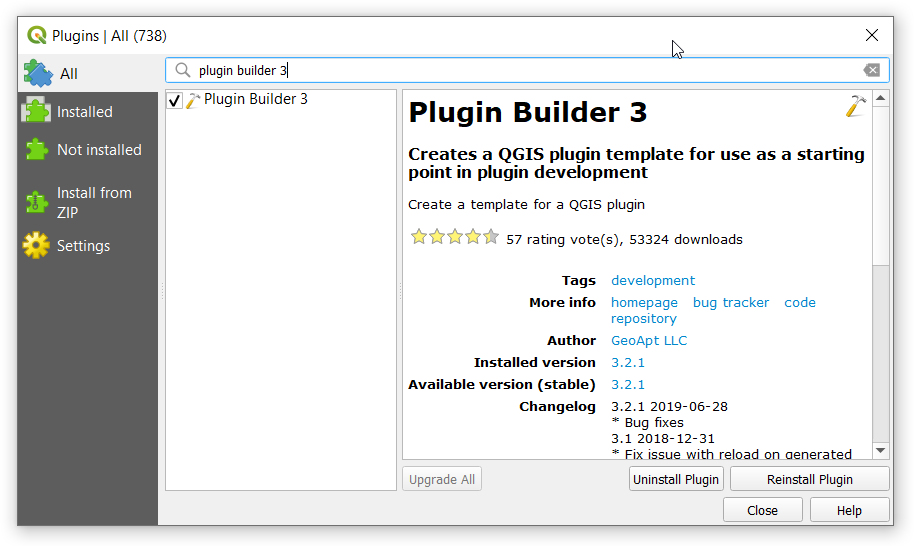

Second, run the plugin by going Plugins -> Plugin Builder in the main menu. 

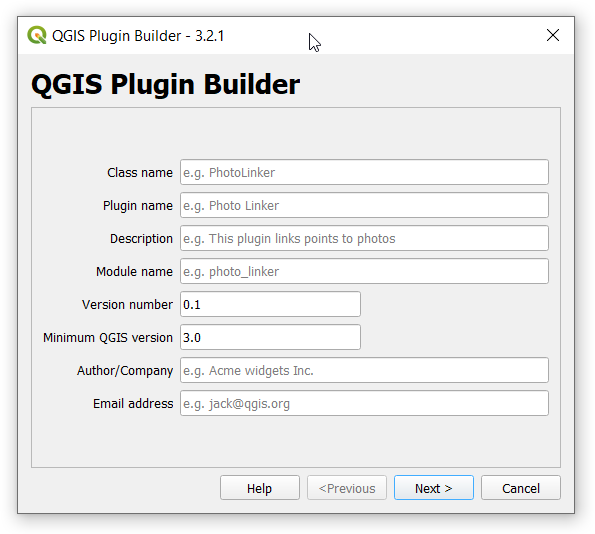

Third, input all information and next. Note that:
* Class name: this is the name of the main class for our plugin. It needs to be a valid Python class name.
* Plugin name: this is the name of the plugin in readable form. In contrast to the class name, it can contain spaces and other special characters.
* Description: a short description of what the plugin is for.
* Module name: the name of the .py file that will contain the main class for your plugin. Typically, the class name written with underscores rather than in CamelCase is used here.
* Version number & Minimum QGIS version: these are used to specify a version number for your plugin and the minimum QGIS version required to run it.
* Author/Company & Email address: here you provide information about the author of the plugin that will be used to create the copyright information at the beginning of the different files. We have no intentation of publishing this plugin, so we just use “489” here.

On the next page, you can enter a longer description of your plugin. Since this is just a toy example, we don’t bother with this here and leave the text as it is.

On the next page, you can choose between different kinds of templates for your plugin, e.g. a simple dialog box or a dock widget, meaning an actual panel that can be docked and moved inside the QGIS GUI like the other panels, e.g. the Layers panel. We here will go with the dock widget.

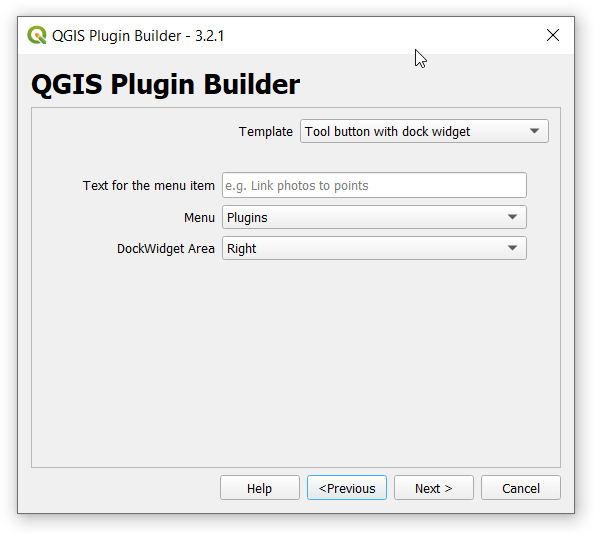

The checkboxes on the next page allow for determining which files Plugin Builder is going to create. It’s ok to leave all options checked.

The next page is specifying information that is relevant if you plan to publish your plugin, e.g. on Github. Since we are not planning this, we just leave the page unchanged.

On the last page, we can determine in which folder the new folder with the files for our plugin will be created. By default this is the default plugin folder of our QGIS installation, meaning the plugin will immediately be listed in QGIS when we start it next. If, instead of the path, you just see a dot (.), please browse to the plugins folder yourself, replacing the part directly after "C:/Users/" with your Windows user name. It is possible that the “AppData” folder in your user’s home directory is not visible in which case you will have to change your settings to show hidden files.

Your plugin PythonSpatialAnalysis was created in:
  C:/Users/user/Desktop/Projects/qgis-vanguard/Day3_S5_Morning\python_spatial_analysis
  
Your QGIS plugin directory is located at:
  C:/Users/user/AppData/Roaming/QGIS/QGIS3/profiles/default/python/plugins
  
What's Next

1. In your plugin directory, compile the resources file using pyrcc5 (simply run make if you have automake or use pb_tool) 
2. Test the generated sources using make test (or run tests from your IDE) 
3. Copy the entire directory containing your new plugin to the QGIS plugin directory (see Notes below) 
4. Test the plugin by enabling it in the QGIS plugin manager 
5. Customize it by editing the implementation file Python_Spatial_Analysis.py 
6. Create your own custom icon, replacing the default icon.png 
7. Modify your user interface by opening Python_Spatial_Analysis_dockwidget_base.ui in Qt Designer 

Notes: 
* You can use the Makefile to compile and deploy when you make changes. This requires GNU make (gmake). The Makefile is ready to use, however you will have to edit it to add addional Python source files, dialogs, and translations. 
* You can also use pb_tool to compile and deploy your plugin. Tweak the pb_tool.cfg file included with your plugin as you add files. Install pb_tool using pip or easy_install. See http://loc8.cc/pb_tool for more information. 

For information on writing PyQGIS code, see http://loc8.cc/pyqgis_resources for a list of resources. 

If we now open the new folder “\python_spatial_analysis” in the QGIS default plugin folder, you will see the following file structure:

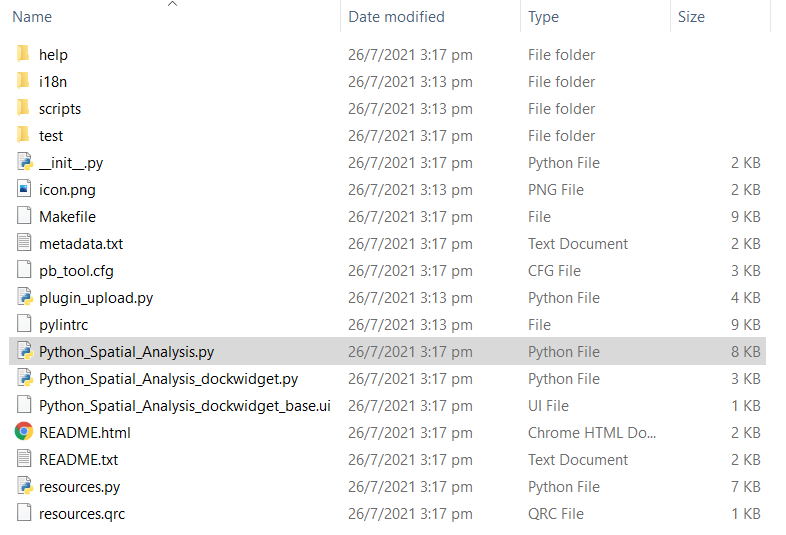

In this introduction, we won’t go into the details of features like internationalization and test code generation, so you can ignore the different subfolders and also some of the files in the main folder. The important files are:

* Python_Spatial_Analysis.py: this file defines the main class PythonSpatialAnalysis for our plugin. If you look at the code that Plugin Builder 3 generated for this class, you will see that this class has to define a number of methods to interact with QGIS and its plugin interface. One central method is the method run() that in this case here shows our dockwidget stored in instance variable self.dockwidget. 

* Python_Spatial_Analysis_dockwidget.py: this is the class that defines the main GUI widget for our plugin derived from QDockWidget. We will talk about this class in more detail in a moment because this is the class that we are going to modify to implement what needs to happen when the user interacts with the GUI of our plugin.
 
* Python_Spatial_Analysis_dockwidget_base.ui: this is the class in which the GUI for our QDockWidget is defined. We will modify it in QT Designer in a moment to adapt the GUI for our purposes.
 
* __init__.py: A file with this name needs to be contained in the main folder of each plugin and it lets QGIS know about the plugin. QGIS calls the classFactory(…) function defined in this file to create an object of the main class of the plugin (class RandomNumberGenerator in this case).

* metadata.txt: this file contains most of the info about our plugin that we entered into Plugin Builder.

## Modifying the Plugin GUI and Adding Functionality

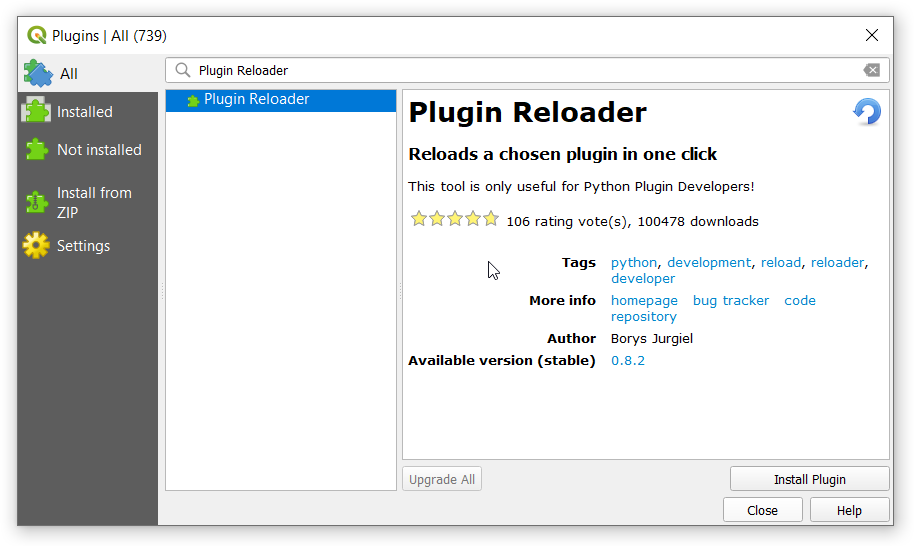

This session introduces techniques for spatial regresssion, which provide us an approach to examine how spatial structure can help better understand the data. 

In [2]:
# if you have not yet installed the pysal, follow the instruction in Session 0 and install pysal

In [1]:
import sys
import os

sys.path.append(r'C:\Program Files\QGIS 3.20.3\apps\qgis\python') #this is important for loading qgis library
sys.path.append(r'C:\Program Files\QGIS 3.20.3\apps\qgis\python\plugins') #this is important for loading processing library

In [2]:
import qgis
from qgis.gui import *
from qgis.core import *
from qgis.utils import plugins
from PyQt5.QtCore import *
from qgis.analysis import QgsNativeAlgorithms

In [8]:
# QgsApplication.setPrefixPath(r'C:\Program Files\QGIS 3.20.0\apps\qgis', True)
# qgs = QgsApplication([], True)
# qgs.initQgis()

In [3]:
%matplotlib inline

from pysal.lib import weights
from pysal.lib import cg as geometry
import contextily
import geopandas as gpd
import seaborn as sb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

C:\Program Files\QGIS 3.20.3\apps\qgis\python\qgis\utils.py:799: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  mod = _builtin_import(name, globals, locals, fromlist, level)


In [4]:
from pysal.model import spreg
from pysal.explore import esda
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split

C:\Program Files\QGIS 3.20.3\apps\qgis\python\qgis\utils.py:799: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  mod = _builtin_import(name, globals, locals, fromlist, level)
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\spopt\region\util.py:21: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def array_from_dict_values(dct, sorted_keys=None, flat_output=False, dtype=np.float):
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\numba\np\ufunc\parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 

## Regression Analysis

We can use regression analysis to:

* Model multiple independent variables
* Include continuous and categorical variables
* Use polynomial terms to model curvature
* Assess interaction terms to determine whether the effect of one independent variable depends on the value of another variable

To answer the following questions:

* Do socio-economic status and race affect educational achievement?
* Do education and IQ affect earnings?
* Do exercise habits and diet effect weight?
* Are drinking coffee and smoking cigarettes related to mortality risk?
* Does a particular exercise intervention have an impact on bone density that is a distinct effect from other physical activities?

For more details, please refer to https://statisticsbyjim.com/regression/when-use-regression-analysis/

If you come from a GIS background, you will realize that these questions are very different from the typical GIS questions: 
* where is the closest shopping mall?
* Which is the shortest path to travel from my current location to the closest shopping mall?
* How many shopping malls in each area?
* How long does it take to travel to the shopping mall?
* Which shopping malls are below sea level?
* Which area has the highest density of shopping malls?
...and so on and so forth...  

Why should we care about the regression analysis? The simple answer is the increasing collaboration among government agencies requires geospatial data analysists to acquire other domain knowledge. One trend of geospatial data science is the integration between geospatial data and statsitics data. For example, to study people shopping behaviors, we will have customers profile information and their location information. To understand the difference between young kids and elderly people's shopping mall preference (physical; not online), we have understand non-spatial data analysis. Actually, long before big data and data science, spatial regression and modelling have widely used in spatial econometrics, mining, fishery, geology, ecology, etc. 

## Non-spatial Linear Regression

Before we discuss how to explicitly include space into the linear regression framework, let us show how basic regression can be carried out in Python, and how one can begin to interpret the results. 

The core idea of linear regression is to explain the variation in a given (*dependent*) variable as a linear function of a collection of other (*explanatory*) variables. For example, in our case, we may want to express/explain the number of inactive or self-employed CPF member as a function of total residents of the area where it is located. At the individual level, we can express this as:

$$
P_i = \alpha + \sum_k \mathbf{X}_{ik}\beta_k  + \epsilon_i
$$

where $P_i$ is the inactive CPF members of subzone $i$, and $X$ is a set of covariates that we use to explain such price. $\beta$ is a vector of parameters that give us information about in which way and to what extent each variable is related to the price, and $\alpha$, the constant term, is the average house price when all the other variables are zero. The term $\epsilon_i$ is usually referred to as "error" and captures elements that influence the inactive CPF members but are not included in $X$. We can also express this relation in matrix form, excluding subindices for $i$, which yields:

$$
P = \alpha + \mathbf{X}\beta + \epsilon
$$

A regression can be seen as a multivariate extension of bivariate correlations. Indeed, one way to interpret the $\beta_k$ coefficients in the equation above is as the degree of correlation between the explanatory variable $k$ and the dependent variable, *keeping all the other explanatory variables constant*. When one calculates bivariate correlations, the coefficient of a variable is picking up the correlation between the variables, but it is also subsuming into it variation associated with other correlated variables -- also called confounding factors. Regression allows us to isolate the distinct effect that a single variable has on the dependent one, once we *control* for those other variables.

Practically speaking, linear regressions in Python are rather streamlined and easy to work with. There are also several packages which will run them (e.g. `statsmodels`, `scikit-learn`, `PySAL`). We start with `statsmodels` and `scikit-learn`, and later on, we will use `PySAL` for linear regression, as `PySAL` that will allow us to move into explicitly spatial econometric models. 

7 Steps to build a Linear Regression model

* 1: Importing the dataset
* 2: Data pre-processing
* 3: Splitting the test and train sets
* 4: Fitting the linear regression model to the training set
* 5: Predicting test results
* 6: Visualizing the test results
* 7: Summarize the results

When performing linear regression in Python, we recommend to use Statsmodels instead of scikit-learn. This is because the Statsmodels library has more advanced statistical tools as compared to sci-kit learn. Moreover, it’s regression analysis tools can give more detailed results. We start with scikit-learn and then use statsmodel.

Before we look at the Singapore social economic data, let's first try a simple dataset: weight-height.csv. 

Generally speaking, there are two different use of linear regression models: prediction and stiatic inference.

### Importing the dataset

In [157]:
dataset = pd.read_csv('Data/weight-height.csv')
dataset.head()

Gender     Height      Weight
0   Male  73.847017  241.893563
1   Male  68.781904  162.310473
2   Male  74.110105  212.740856
3   Male  71.730978  220.042470
4   Male  69.881796  206.349801

### Data Preprocessing

In [158]:
X = dataset.iloc[:,1].values  #independent variable array
y = dataset.iloc[:,2].values  #dependent variable vector

In [159]:
X

array([73.84701702, 68.78190405, 74.11010539, ..., 63.86799221,
       69.03424313, 61.94424588])

In [160]:
y

array([241.89356318, 162.31047252, 212.74085556, ..., 128.47531878,
       163.85246135, 113.64910268])

### Splitting the dataset

We need to split our dataset into the test and train set. 

In [161]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=1/4,random_state=0)

### Fitting linear regression model into the training set

In [162]:
regressor = LinearRegression()

regressor.fit(X_train.reshape(-1, 1),y_train) #actually produces the linear eqn for the data

LinearRegression()

### Predicting the test set results

In [163]:
y_test_pred = regressor.predict(X_test.reshape(-1,1)) 
y_test_pred

array([148.71918181, 168.38777621, 224.33647637, ..., 177.05541851,
       152.24692441, 117.82424099])

In [164]:
y_test

array([138.0857961 , 187.36336585, 216.53319128, ..., 169.63439905,
       169.45963091, 123.62835958])

### Visualizing the results

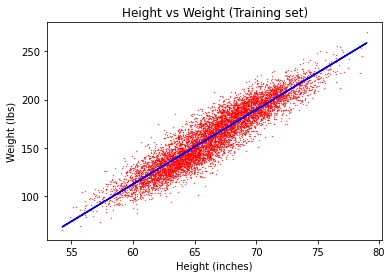

In [165]:
#plot for the TRAIN
plt.scatter(X_train, y_train, color='red',s =.1) # plotting the observation line
plt.plot(X_train, regressor.predict(X_train.reshape(-1,1)), color='blue') # plotting the regression line
plt.title("Height vs Weight (Training set)") # stating the title of the graph
plt.xlabel("Height (inches)") # adding the name of x-axis
plt.ylabel("Weight (lbs)") # adding the name of y-axis
plt.show() # specifies end of graph

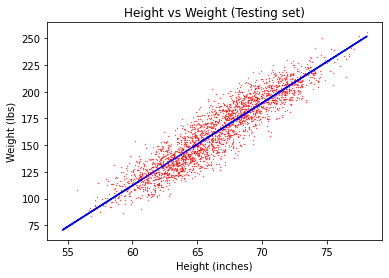

In [166]:
#plot for the TEST
plt.scatter(X_test, y_test, color='red', s=.1) 
plt.plot(X_test, y_test_pred, color='blue') # plotting the regression line

plt.title("Height vs Weight (Testing set)") # stating the title of the graph
plt.xlabel("Height (inches)") # adding the name of x-axis
plt.ylabel("Weight (lbs)") # adding the name of y-axis
plt.show() # specifies end of graph

### Summarize the results

In [167]:
def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [168]:
regression_results(y_test,y_test_pred)

explained_variance:  0.8547
mean_squared_log_error:  0.0064
r2:  0.8547
MAE:  9.8151
MSE:  151.47
RMSE:  12.3073


In [169]:
regression_results(y_train, regressor.predict(X_train.reshape(-1,1)))

explained_variance:  0.8553
mean_squared_log_error:  0.0063
r2:  0.8553
MAE:  9.7236
MSE:  148.5696
RMSE:  12.1889


### Improve the Linear Model to Explain More Variance 

In [170]:
dataset_dummies = pd.get_dummies(dataset.Gender, prefix='Gender').drop('Gender_Male', axis=1)
dataset_dummies.head()

# Take our numeric features and our output label
dataset_features = dataset[['Height', 'Weight']]

# Combine into one dataframe
df = pd.concat([dataset_dummies,dataset_features], axis=1)
df.head()

Gender_Female     Height      Weight
0              0  73.847017  241.893563
1              0  68.781904  162.310473
2              0  74.110105  212.740856
3              0  71.730978  220.042470
4              0  69.881796  206.349801

In [171]:
# another of adding the dummies 
# dataset['Gender_Female'] = (dataset.Gender == 'Female').astype(int)
# dataset.head()

In [172]:
X = df.iloc[:,[0,2]].values  #independent variable array
y = df.iloc[:,1].values  #dependent variable vector
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=1/4,random_state=0)
regressor = LinearRegression()
regressor.fit(X_train,y_train) #actually produces the linear eqn for the data
y_test_pred = regressor.predict(X_test) 
y_test_pred
regression_results(y_test,y_test_pred)

explained_variance:  0.8604
mean_squared_log_error:  0.0005
r2:  0.8604
MAE:  1.1623
MSE:  2.0902
RMSE:  1.4458


In [173]:
# regression R2 score of train data
regressor.score(X_train, y_train)

0.8610714286881407

### Use StatsModels for Linear regression

In [174]:
X = df.iloc[:,[0,2]]  #independent variable array
y = df.iloc[:,1]#dependent variable vector

In [175]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=1/4,random_state=0)

In [176]:
X_train_ = sm.add_constant(X_train)

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [177]:
model = sm.OLS(y_train,X_train_).fit()

In [178]:
model.params

const            46.057440
Gender_Female     0.964712
Weight            0.122832
dtype: float64

In [179]:
(model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Height   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                 2.323e+04
Date:                Wed, 06 Oct 2021   Prob (F-statistic):               0.00
Time:                        15:41:20   Log-Likelihood:                -13332.
No. Observations:                7500   AIC:                         2.667e+04
Df Residuals:                    7497   BIC:                         2.669e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            46.0574      0.162    284.646      0.000      45.740      46.375
Gender_Female     0.9647      0.055     17.582      0.000       0.857       1.072
Weight            0.1228      0.001    143.483      0.000       0.121       0.125
==============================================================================
Omnibus:                        2.027   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.363   Jarque-Bera (JB):                1.982
Skew:                          -0.034   Prob(JB):                        0.371
Kurtosis:                       3.043   Cond. No.                     1.68e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.68e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

* R-squared value: This is a statistical measure of how well the regression line fits with the real data points. The higher the value, the better the fit.
* Adj, R-squared: This is the corrected R-squared value according to the number of input features. Ideally, it should be close to the R-squareds value.
* Coefficient: It tells how much the weight changes with a unit change in height. A positive value means that the two variables are directly proportional. A negative value, however, would have meant that the two variables are inversely proportional to each other.
* Std error:  This tells us how accurate our coefficient value is. The lower the standard error, the higher the accuracy.
* P >|t| : This is the p-value. A value less than 0.05 usually means that it is quite significant.

## Use Linear Regresssion for Statistic Inference

Linear regresssion with big data is mostly a data fitting issue. Actually, many research cannot afford to get all the data. Instead, they only sample a few data and use it for statistic inference.
 
In simple linear regression, statistical inference includes both slopes and intercepts. We will focus on the slope since our interest is usually in the strength of the linear relationship (i.e. correlation) between two variables. 

One research question is: is female taller than male?

In [180]:
# the population data indicates that male is taller and heavier than female.  
dataset.groupby('Gender').mean()

Height      Weight
Gender                       
Female  63.708774  135.860093
Male    69.026346  187.020621

In [57]:
# if we only sample 40 data records (20 female and 20 maile), the sample mean of male is larger than the sample female. 
sample_dataset1 = dataset.groupby('Gender').apply(lambda x: x.sample(n=20))

In [58]:
sample_dataset1.reset_index(drop=True, inplace=True)

In [59]:
sample_dataset1.groupby('Gender').mean()

Height      Weight
Gender                       
Female  62.571684  133.306408
Male    68.517026  180.456773

In [63]:
# Is it possible that some research teams just sampled 20 females and 20 males, and females on average are taller than men?
dataset.sort_values('Height').groupby('Gender').apply(lambda x: x.tail(20) if x.name=="Female" else x.head(20))

Gender     Height      Weight
Gender                                    
Female 5687  Female  70.664300  162.281555
       7710  Female  70.664865  184.517960
       8748  Female  70.697143  194.048809
       5092  Female  70.710140  161.363484
       7400  Female  70.742086  180.053866
       9846  Female  70.751410  192.583639
       8732  Female  70.817538  184.860624
       7527  Female  70.837103  192.160585
       5976  Female  70.932194  175.954401
       8736  Female  70.950659  193.225927
       8464  Female  71.070451  182.083580
       9424  Female  71.122793  176.040345
       7924  Female  71.277507  162.313393
       6116  Female  71.438947  175.035492
       8135  Female  71.552205  185.658271
       5103  Female  71.991257  177.366002
       8635  Female  72.088712  192.530863
       7856  Female  72.264748  188.437304
       7162  Female  72.429771  177.969532
       7311  Female  73.389586  190.078729
Male   4794    Male  58.406905  121.338323
       2334    Male  59.380650  136.391006
       4637    Male  59.868078  117.803842
       2191    Male  59.938650  141.459579
       1942    Male  59.981865  112.902939
       3020    Male  60.217019  146.956646
       4170    Male  60.243718  153.831429
       2974    Male  60.267190  132.948179
       2527    Male  60.269108  126.455613
       1238    Male  60.363312  134.146848
       4980    Male  60.614115  156.458355
       551     Male  60.679817  129.301024
       3332    Male  60.721080  123.628360
       426     Male  60.748118  136.167866
       1577    Male  60.798886  128.390221
       1442    Male  60.820271  137.775310
       2925    Male  60.935740  140.151716
       2959    Male  60.936236  152.349380
       1715    Male  60.966723  134.822827
       4324    Male  60.972032  150.865014

In [64]:
# we can sample again, and each time the result is different
sample_dataset2 = dataset.groupby('Gender').apply(lambda x: x.sample(n=20))

In [65]:
sample_dataset2.reset_index(drop=True, inplace=True)

In [66]:
sample_dataset2.groupby('Gender').mean()

Height      Weight
Gender                       
Female  63.010084  129.321734
Male    69.092559  187.863668

The issue is if we have hundereds or thousands of research teams and each team has a differernt sample. How certain we are about the results of one single team? Shall we trust their research findings based on a small dataset? Let's assume that there are 1000 teams are studing the heights of this town and each team has a different sample from the population. We can simulate 1000 samples using Pandas.

In [67]:
samples_1000 = [dataset.groupby('Gender').apply(lambda x: x.sample(n=20)).assign(SampleID=i+1) for i in range(0 ,1000)]
samples = pd.concat(samples_1000)
samples.reset_index(drop=True, inplace=True)
samples

Gender     Height      Weight  SampleID
0      Female  65.250519  135.303222         1
1      Female  68.059839  176.244420         1
2      Female  63.489644  133.142449         1
3      Female  59.125031   90.520784         1
4      Female  59.997806  113.651111         1
...       ...        ...         ...       ...
39995    Male  71.427575  201.842809      1000
39996    Male  70.097238  201.993728      1000
39997    Male  62.600248  151.720704      1000
39998    Male  66.423775  167.393255      1000
39999    Male  65.937352  160.490289      1000

[40000 rows x 4 columns]

In [68]:
dist=samples.groupby(['SampleID','Gender']).mean().reset_index()

<AxesSubplot:xlabel='Height', ylabel='Count'>

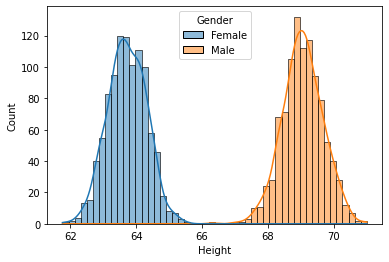

In [69]:
g=sb.histplot(data=dist, x="Height",bins=50, kde=True,hue="Gender")
g

what is a t-test? It is a type of inferential statistic used to study if there is a statistical difference between two groups. Mathematically, it establishes the problem by assuming that the means of the two distributions are equal (H₀: µ₁=µ₂). If the t-test rejects the null hypothesis (H₀: µ₁=µ₂), it indicates that the groups are highly probably different.

This test should be implemented when the groups have 20–30 samples. If we want to examine more groups or larger sample sizes, there are other tests more accurate than t-tests such as z-test, chi-square test or f-test.

In [242]:
samples_1000[200].query('Gender == "Female"').filter(items='Height').values

array([], shape=(20, 0), dtype=float64)

In [257]:
x1=samples_1000[200].reset_index(drop=True).query('Gender == "Female"')['Height']
x2=samples_1000[200].reset_index(drop=True).query('Gender == "Male"')['Height']

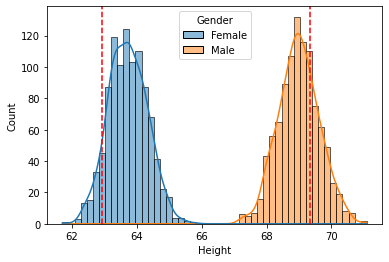

In [270]:
g=sb.histplot(data=dist, x="Height",bins=50, kde=True,hue="Gender")
ax = g.axes
ax.axvline(x1.mean(), ls='--',color='r')
ax.axvline(x2.mean(), ls='--',color='r')

In [284]:
dist

SampleID  Gender     Height      Weight
0            1  Female  64.066877  136.644860
1            1    Male  68.200832  181.784184
2            2  Female  63.731078  137.039983
3            2    Male  67.964507  179.509875
4            3  Female  64.526552  141.314658
...        ...     ...        ...         ...
1995       998    Male  68.610862  185.066927
1996       999  Female  64.191150  139.062758
1997       999    Male  69.071935  186.626583
1998      1000  Female  63.805494  136.664533
1999      1000    Male  69.207293  190.525746

[2000 rows x 4 columns]

In [298]:
# normalize the data
dist['z_height'] = (dist['Height'] - dist['Height'].mean())/dist['Height'].std()

In [299]:
dist

SampleID  Gender     Height      Weight  z_height
0            1  Female  64.066877  136.644860 -0.846499
1            1    Male  68.200832  181.784184  0.680487
2            2  Female  63.731078  137.039983 -0.970536
3            2    Male  67.964507  179.509875  0.593194
4            3  Female  64.526552  141.314658 -0.676706
...        ...     ...        ...         ...       ...
1995       998    Male  68.610862  185.066927  0.831943
1996       999  Female  64.191150  139.062758 -0.800596
1997       999    Male  69.071935  186.626583  1.002252
1998      1000  Female  63.805494  136.664533 -0.943048
1999      1000    Male  69.207293  190.525746  1.052251

[2000 rows x 5 columns]

In [300]:
diff=dist.query('Gender == "Female"')['z_height'].values-dist.query('Gender == "Male"')['z_height'].values

In [301]:
df1=pd.DataFrame({'diff':diff,'SampleID':range(1,1001)})

In [302]:
df1

diff  SampleID
0   -1.526986         1
1   -1.563730         2
2   -1.955149         3
3   -1.395210         4
4   -1.920149         5
..        ...       ...
995 -1.831893       996
996 -1.943302       997
997 -1.736792       998
998 -1.802848       999
999 -1.995299      1000

[1000 rows x 2 columns]

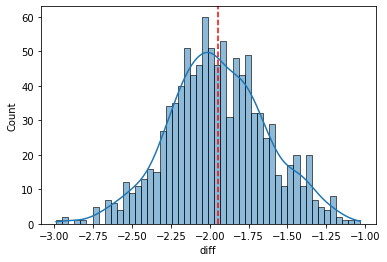

In [304]:
g=sb.histplot(data=df1, x="diff",bins=50, kde=True)
ax = g.axes
ax.axvline(df1['diff'].mean(), ls='--',color='r')

The central limit theorem
1. For large enough sample sizes, the sampling distribution of the
means will be approximately normal, regardless of the
underlying distribution (as long as this distribution has a mean
and variance defined for it).
2. This will be the basis for statistical inference.

In [314]:
s = np.random.standard_t(18, size=1000)

<AxesSubplot:ylabel='Count'>

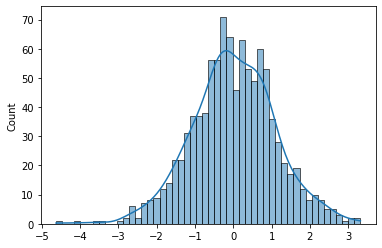

In [322]:
sb.histplot(data=s, bins=50, kde=True)

<AxesSubplot:xlabel='diff', ylabel='Count'>

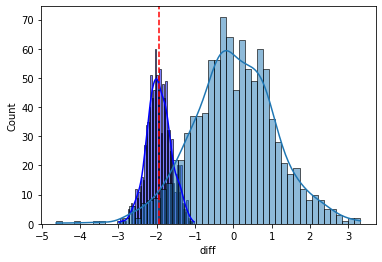

In [323]:
g=sb.histplot(data=df1, x="diff",bins=50, kde=True, color="b",alpha=0.5)
ax = g.axes
ax.axvline(df1['diff'].mean(), ls='--',color='r')
sb.histplot(data=s, bins=50, kde=True,ax=ax,alpha=0.5)

The Z-score allows you to decide if your sample is different from the population mean. In order to use z, you must know four things:
* The population mean.
* The population standard deviation.
* The sample mean.
* The sample size.
Usually in stats, you don’t know anything about a population, so instead of a Z score you use a T Test with a T Statistic. The major difference between using a Z score and a T statistic is that you have to estimate the population standard deviation. The T test is also used if you have a small sample size (less than 30).

In [313]:
# return t statistics, p value, and degree of freedom
ttest_ind(x1,x2)

(-7.267764376018372, 1.070982025077357e-08, 38.0)

So, given a sample and null hypothesis mean µ, we can compute
the quantity:
    $$ t =(\bar x − µ)/SE $$

In [372]:
x_bar = np.mean(x1.values - x2.values)
mu = 0
se = np.std(x1.values - x2.values,ddof=1)/np.sqrt(len(x1.values - x2.values)-1)
t =(x_bar - mu)/se
t

-8.238956453351134

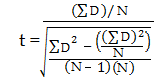

* ΣD: Sum of the differences (Sum of X-Y from Step 2)
* ΣD2: Sum of the squared differences
* (ΣD)2: Sum of the differences squared.

In [774]:
stats.ttest_ind(x1, x2)

Ttest_indResult(statistic=-7.267764376018372, pvalue=1.070982025077357e-08)

### Visualize Sample Correlation Coefficient (slope)

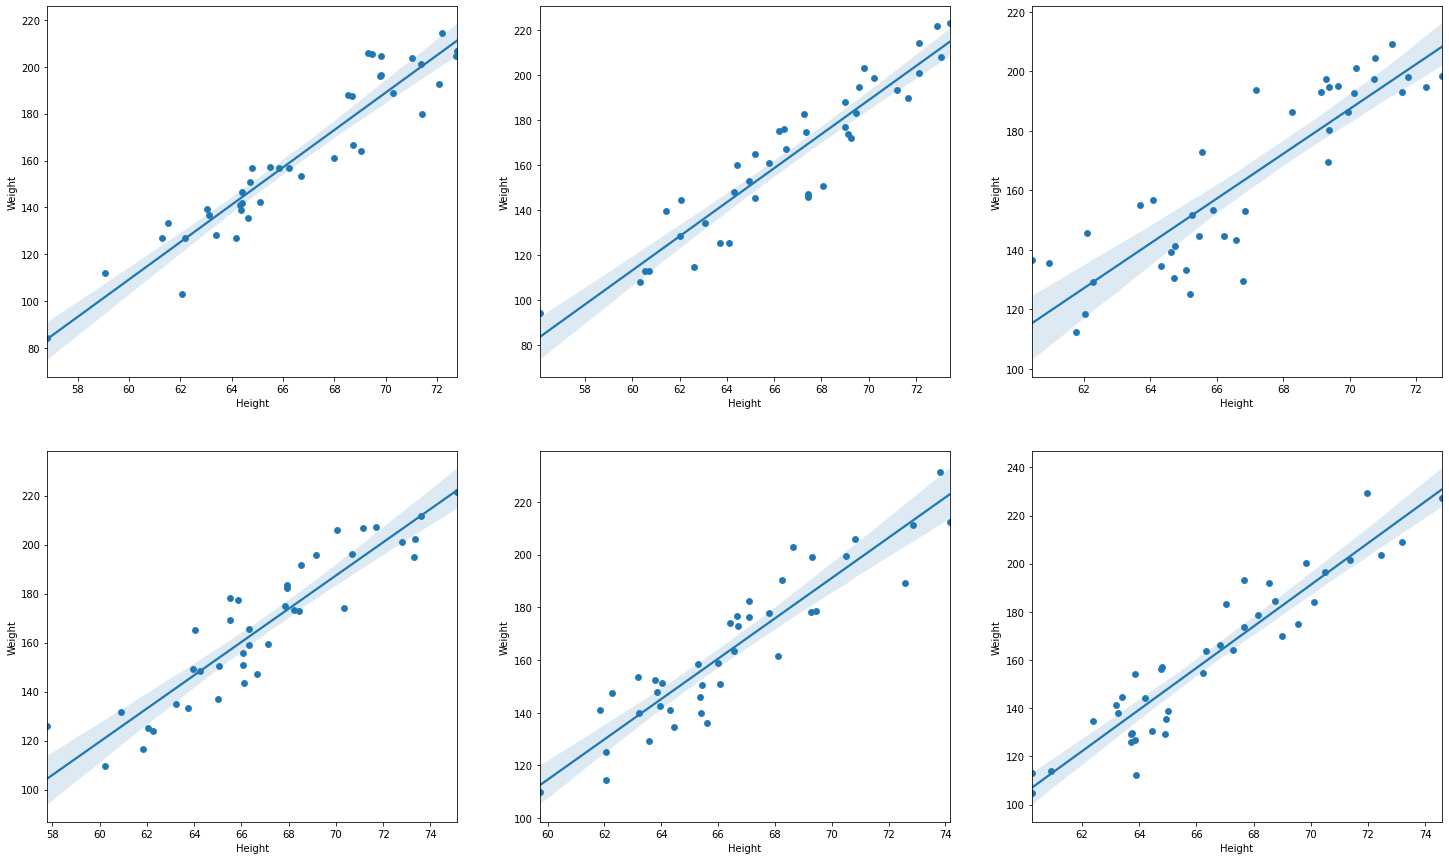

In [398]:
fig, axes = plt.subplots(2, 3,figsize=(25,15))
ax=axes.flatten()

# [sb.scatterplot(samples_1000[num], x="Height",y="Weight",ax=ax[i]) for i, num in enumerate(np.random.randint(0, 1000, 6))]
for i, num in enumerate(np.random.randint(0, 1000, 6)):
    sb.scatterplot(data=samples_1000[num], x="Height", y="Weight",ax=ax[i])
    sb.regplot(data=samples_1000[num], x="Height", y="Weight",ax=ax[i])

### Calculate all Sample Correlation Coefficients

In [401]:
def cal_coeff(df):
    X_train_ = sm.add_constant(df['Height'])
    model = sm.OLS(df['Weight'],X_train_).fit()
    return model.params

In [411]:
params_1000=[cal_coeff(i) for i in samples_1000]

In [413]:
params_1000_df=pd.DataFrame(params_1000)

In [417]:
params_1000_df

const    Height
0   -358.801426  7.832841
1   -357.935634  7.839451
2   -303.388074  6.959969
3   -363.145743  7.910753
4   -384.373279  8.260786
..          ...       ...
995 -385.798443  8.203656
996 -312.261404  7.132436
997 -365.431578  7.938033
998 -351.777983  7.723409
999 -369.372439  8.013780

[1000 rows x 2 columns]

In [439]:
intercept=1
slope=1
x_vals = np.arange(50, 80, 0.1)  
y_vals = intercept + slope * x_vals
data=pd.DataFrame({"x":x_vals,"y":y_vals})

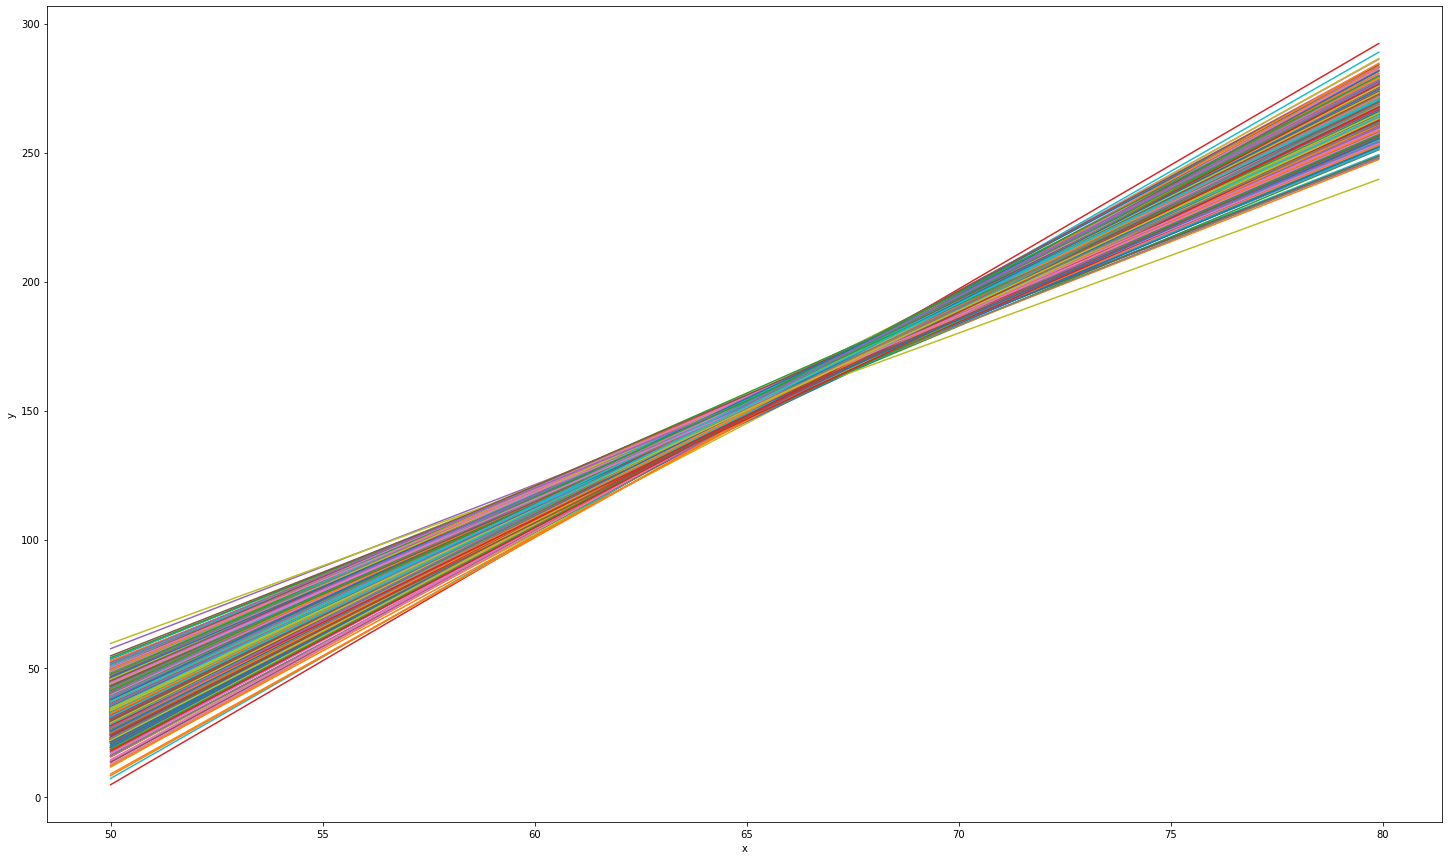

In [447]:
fig, ax = plt.subplots(1, 1,figsize=(25,15))

for i, j in zip(params_1000_df['const'],params_1000_df['Height']):
    x_vals = np.arange(50, 80, 0.1)  
    y_vals = i + j * x_vals
    dt=pd.DataFrame({"x":x_vals,"y":y_vals})
    sb.lineplot(data=dt,x="x",y="y",ax=ax)

### Hypthesis Testing using Statsmodels

In [192]:
formula = 'Weight ~ Gender * Height'
# formula2 = 'Weight ~ Height'
# formula3 = 'Weight ~ Gender + Height'
dataset = sm.add_constant(dataset)
results = ols(formula, dataset).fit()
results.summary()

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Weight   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                 3.093e+04
Date:                Wed, 06 Oct 2021   Prob (F-statistic):               0.00
Time:                        15:45:42   Log-Likelihood:                -37228.
No. Observations:               10000   AIC:                         7.446e+04
Df Residuals:                    9996   BIC:                         7.449e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              -246.0133      3.350    -73.443      0.000    -252.579    -239.447
Gender[T.Male]           21.5144      4.785      4.496      0.000      12.134      30.895
Height                    5.9940      0.053    114.103      0.000       5.891       6.097
Gender[T.Male]:Height    -0.0323      0.072     -0.447      0.655      -0.174       0.109
==============================================================================
Omnibus:                        0.470   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.790   Jarque-Bera (JB):                0.452
Skew:                           0.015   Prob(JB):                        0.798
Kurtosis:                       3.011   Cond. No.                     4.22e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.22e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [193]:
hypotheses = '(Gender[T.Male]=20)'
f_test = results.t_test(hypotheses)

In [194]:
f_test

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            21.5144      4.785      0.316      0.752      12.134      30.895

## Hidden Spatial Structures? 

In general, our model performs well, being able to predict slightly more than 90% ($R^2=0.903$) of the variation in the weight using gender and height. But, our model might display some clustering in errors. To interrogate this, we can do a few things. 

In [195]:
dataset['res'] = results.resid
dataset['pred'] = results.predict()
dataset['res_z'] = stats.zscore(dataset['res'])

In [196]:
dataset.dtypes

const     float64
Gender     object
Height    float64
Weight    float64
res       float64
pred      float64
res_z     float64
dtype: object

In [197]:
dataset.assign(Nationality = "")
dataset.loc[dataset['res_z'] > 1.5, 'Nationality'] = "Country 1"
dataset.loc[dataset['res_z'] < -1.5, 'Nationality'] = "Country 2"
dataset.loc[(dataset['res_z'] <=1.5) & (dataset['res_z'] >=-1.5), 'Nationality'] = "Country 3"

In [198]:
dataset

const  Gender     Height      Weight        res        pred     res_z  \
0       1.0    Male  73.847017  241.893563  26.133192  215.760371  2.610060   
1       1.0    Male  68.781904  162.310473 -23.252841  185.563314 -2.322384   
2       1.0    Male  74.110105  212.740856  -4.587989  217.328845 -0.458227   
3       1.0    Male  71.730978  220.042470  16.897442  203.145028  1.687637   
4       1.0    Male  69.881796  206.349801  14.229181  192.120620  1.421143   
...     ...     ...        ...         ...        ...         ...       ...   
9995    1.0  Female  66.172652  136.777454 -13.851242  150.628696 -1.383397   
9996    1.0  Female  67.067155  170.867906  14.877520  155.990386  1.485896   
9997    1.0  Female  63.867992  128.475319  -8.339138  136.814457 -0.832874   
9998    1.0  Female  69.034243  163.852461  -3.928744  167.781206 -0.392384   
9999    1.0  Female  61.944246  113.649103 -11.634329  125.283432 -1.161982   

     Nationality  
0      Country 1  
1      Country 2  
2      Country 3  
3      Country 1  
4      Country 3  
...          ...  
9995   Country 3  
9996   Country 3  
9997   Country 3  
9998   Country 3  
9999   Country 3  

[10000 rows x 8 columns]

In [199]:
formula = 'Weight ~ Gender + Height + Nationality'
dataset = sm.add_constant(dataset)
results = ols(formula, dataset).fit()
results.summary()

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Weight   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                 4.886e+04
Date:                Wed, 06 Oct 2021   Prob (F-statistic):               0.00
Time:                        15:46:13   Log-Likelihood:                -33765.
No. Observations:               10000   AIC:                         6.754e+04
Df Residuals:                    9995   BIC:                         6.758e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                 -226.1737      1.645   -137.485      0.000    -229.398    -222.949
Gender[T.Male]              19.3063      0.196     98.496      0.000      18.922      19.691
Nationality[T.Country 2]   -38.9179      0.390    -99.915      0.000     -39.681     -38.154
Nationality[T.Country 3]   -19.5916      0.285    -68.783      0.000     -20.150     -19.033
Height                       5.9896      0.025    235.124      0.000       5.940       6.040
==============================================================================
Omnibus:                      509.773   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              200.286
Skew:                           0.004   Prob(JB):                     3.22e-44
Kurtosis:                       2.307   Cond. No.                     1.55e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.55e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<AxesSubplot:xlabel='Height', ylabel='Weight'>

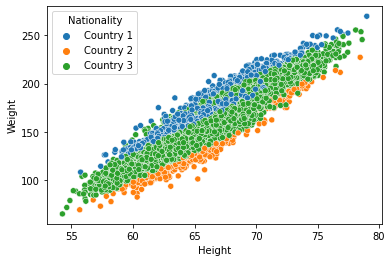

In [200]:
sb.scatterplot(data=dataset,x="Height",y="Weight", hue="Nationality")

<AxesSubplot:xlabel='Height', ylabel='Weight'>

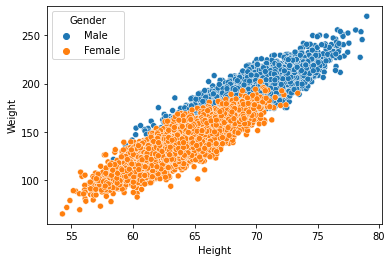

In [86]:
sb.scatterplot(data=dataset,x="Height",y="Weight", hue="Gender")

Is the Nationality attribute spatial? The simple answer is No. Country is just like another categorical variable Gender in the dataset.
What if we add coordinates of the three countries? Do the coordindates X, Y make the regresssion spatial? 

In [201]:
dataset.assign(X = 0,Y=0)
dataset.loc[dataset['Nationality'] == "Country 1", ['X','Y']] = [0,0]
dataset.loc[dataset['Nationality'] == "Country 2", ['X','Y']] = [100,0]
dataset.loc[dataset['Nationality'] == "Country 3", ['X','Y']] = [50,100*np.sin(np.pi/4)]

In [202]:
dataset_xy = dataset.groupby('Nationality').mean()
dataset_xy.reset_index(inplace=True)

In [203]:
dataset_xy

Nationality  const     Height      Weight        res        pred     res_z  \
0   Country 1    1.0  66.270565  180.415978  19.557269  160.858709  1.953288   
1   Country 2    1.0  66.341145  141.906095 -19.361785  161.267880 -1.933764   
2   Country 3    1.0  66.377005  161.462974  -0.035087  161.498061 -0.003504   

       X          Y  
0    0.0   0.000000  
1  100.0   0.000000  
2   50.0  70.710678

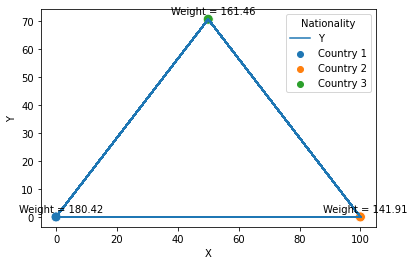

In [204]:
ax1 = dataset.plot(x="X",y="Y")
sb.scatterplot(data=dataset_xy,x='X',
                      y='Y',hue="Nationality",
                      ax=ax1, s=100)

for x,y,z in zip(dataset_xy.X,dataset_xy.Y,dataset_xy.Weight):
    label = f"Weight = {z:.2f}"
    ax1.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(5,5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

In [205]:
formula = 'Weight ~ Gender + Height + Nationality + X * Y'
dataset = sm.add_constant(dataset)
results = ols(formula, dataset).fit()
results.summary()

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Weight   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                 4.884e+04
Date:                Wed, 06 Oct 2021   Prob (F-statistic):               0.00
Time:                        15:46:29   Log-Likelihood:                -33767.
No. Observations:               10000   AIC:                         6.754e+04
Df Residuals:                    9995   BIC:                         6.758e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                 -226.3052      1.658   -136.490      0.000    -229.555    -223.055
Gender[T.Male]              19.3093      0.196     98.464      0.000      18.925      19.694
Nationality[T.Country 2] -8.518e+07   1.32e+08     -0.644      0.519   -3.44e+08    1.74e+08
Nationality[T.Country 3]  8.083e+07   1.25e+08      0.644      0.519   -1.65e+08    3.27e+08
Height                       5.9895      0.025    235.054      0.000       5.940       6.039
X                         8.518e+05   1.32e+06      0.644      0.519   -1.74e+06    3.44e+06
Y                        -7.888e+09   1.22e+10     -0.644      0.519   -3.19e+10    1.61e+10
X:Y                       1.577e+08   2.45e+08      0.644      0.519   -3.22e+08    6.38e+08
==============================================================================
Omnibus:                      512.411   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              200.928
Skew:                          -0.006   Prob(JB):                     2.34e-44
Kurtosis:                       2.306   Cond. No.                     8.96e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.35e-23. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## What exactly does *linear* mean in linear regression? 

Better understand Linear vs Non-Linear regression. 

It is possible to model curvature with this type of model. While the function must be linear in the parameters, you can raise an independent variable by an exponent to fit a curve. For example, if you square an independent variable, the model can follow a U-shaped curve.

$$Y =\beta _{0} + \beta _{1}X_{1} + \beta _{2}X_{1}^2$$
While the independent variable is squared, the model is still linear in the parameters. Linear models can also contain log terms and inverse terms to follow different kinds of curves and yet continue to be linear in the parameters.

In [600]:
nsample = 50
sig = 0.5
x = np.linspace(0, 20, nsample)
X = np.column_stack((x, np.sin(x), (x-5)**2, np.ones(nsample))) # np.ones(nsample)) are constant

beta = [0.5, 0.5, -0.02, 5.]

y_true = np.dot(X, beta)
y = y_true + sig * np.random.normal(size=nsample)

In [601]:
res = sm.OLS(y, X).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     248.4
Date:                Wed, 04 Aug 2021   Prob (F-statistic):           2.04e-28
Time:                        11:11:18   Log-Likelihood:                -32.964
No. Observations:                  50   AIC:                             73.93
Df Residuals:                      46   BIC:                             81.58
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.5079      0.026     19.808      0.0

In [602]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std

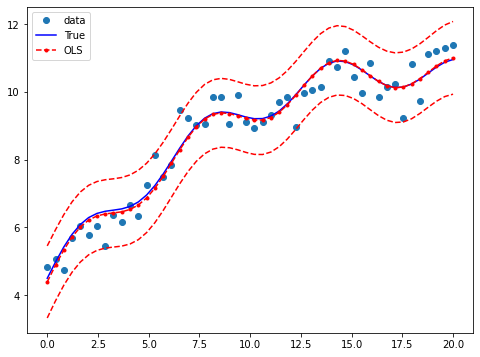

In [603]:
prstd, iv_l, iv_u = wls_prediction_std(res)

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(x, y, 'o', label="data")
ax.plot(x, y_true, 'b-', label="True")
ax.plot(x, res.fittedvalues, 'r--.', label="OLS")
ax.plot(x, iv_u, 'r--')
ax.plot(x, iv_l, 'r--')
ax.legend(loc='best');

In [604]:
X1 = np.column_stack((x,np.ones(nsample)))
res = sm.OLS(y, X1).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     222.8
Date:                Wed, 04 Aug 2021   Prob (F-statistic):           1.16e-19
Time:                        11:11:35   Log-Likelihood:                -60.834
No. Observations:                  50   AIC:                             125.7
Df Residuals:                      48   BIC:                             129.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2988      0.020     14.927      0.0

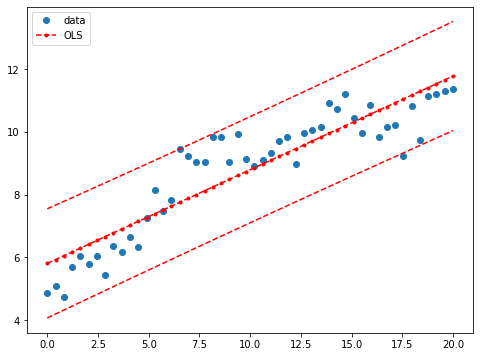

In [605]:
prstd, iv_l, iv_u = wls_prediction_std(res)

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(x, y, 'o', label="data")
ax.plot(x, res.fittedvalues, 'r--.', label="OLS")
ax.plot(x, iv_u, 'r--')
ax.plot(x, iv_l, 'r--')
ax.legend(loc='best');

A nonlinear model is literally not linear. The added flexibility opens the door to a huge number of possible forms. Consequently, nonlinear regression can fit an enormous variety of curves. However, because there are so many candidates, you may need to conduct some research to determine which functional form provides the best fit for your data. Notice how nonlinear regression equations are not comprised of only addition and multiplication! 
$$Y =\beta _{0} + \beta _{1}^{X_{1}} + \beta _{2}^{X_{1}^2}$$
$$Y =\beta _{0} + \exp^{\beta _{1} * X_{1}}$$
$$Y =\beta _{0} + sin(\beta _{1} * X_{1})$$

It’s important to note that R-squared is invalid for nonlinear models.

### Ordinary Least Squares Assumptions

OLS measures the accuracy of a linear regression model.

OLS is built on assumptions which, if held, indicate the model may be the correct lens through which to interpret our data. If the assumptions don't hold, our model's conclusions lose their validity.

Here are the OLS assumptions:

* Linearity: A linear relationship exists between the dependent and predictor variables. If no linear relationship exists, linear regression isn't the correct model to explain our data.
* No multicollinearity: Predictor variables are not collinear, i.e., they aren't highly correlated. If the predictors are highly correlated, try removing one or more of them. Since additional predictors are supplying redundant information, removing them shouldn't drastically reduce the Adj. R-squared (see below).
* Zero conditional mean: The average of the distances (or residuals) between the observations and the trend line is zero. Some will be positive, others negative, but they won't be biased toward a set of values.
* Homoskedasticity: The certainty (or uncertainty) of our dependent variable is equal across all values of a predictor variable; that is, there is no pattern in the residuals. In statistical jargon, the variance is constant.
* No autocorrelation (serial correlation): Autocorrelation is when a variable is correlated with itself across observations. For example, a stock price might be serially correlated if one day's stock price impacts the next day's stock price.

### Exercise Singapore Social-Economic Data 

Run a linear regression analysis to study the research question:
> Do socio-economic information including age population ('Age_0to6', 'Age_20to29', 'Age_over85'), real estate annual value ('HDB_AV_E', 'HDB_AV_2rm',House_AV', 'Condo_AV', 'EC_AV', 'Apart_AV') and foreign employee VISA type ('DP', 'FDW','WP') affect the number of inactive CPF members (i.e., self-employed or unemployed)?


In [6]:
sz_cpf = gpd.read_file('Data/MP14_Subzone_CPF_2017.shp')

In [7]:
not_varaible_names=['SUBZONE_N', 'PLN_AREA_N', 'REGION_N','SUBZONE_C', 
                    'PLN_AREA_C', 'REGION_C', 'geometry','stud_lprim',
                    'HDB_AV_1rm','e12k_Over','stud_jcoll','VariableX']
variable_names = sz_cpf.columns[~sz_cpf.columns.isin(not_varaible_names)]
sz_df = sz_cpf[variable_names]

In [8]:
variable_names

Index(['Age_0to6', 'Age_20to29', 'Age_over85', 'HDB_AV_E', 'HDB_AV_2rm',
       'House_AV', 'Condo_AV', 'EC_AV', 'Apart_AV', 'DP', 'FDW', 'WP',
       'Ina_CPF_N'],
      dtype='object')

In [9]:
formula = 'Ina_CPF_N ~ Age_0to6'

In [200]:
# variable_names_X = variable_names.values.tolist()
# variable_names_X.remove('Ina_CPF_N')
# variable_formula = "+".join(variable_names_X)
# variable_formula

In [201]:
# formula = 'Ina_CPF_N ~ ' + '+'.join(variable_formula)
# formula = 'Ina_CPF_N ~ Age_0to6+Age_20to29+Age_over85+HDB_AV_E+HDB_AV_2rm+House_AV+Condo_AV+EC_AV+Apart_AV+DP+FDW+WP'

In [10]:
sz_df = sm.add_constant(sz_df)
results = ols(formula, sz_df).fit()
results.summary()

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Ina_CPF_N   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     530.8
Date:                Wed, 06 Oct 2021   Prob (F-statistic):           7.51e-70
Time:                        14:58:18   Log-Likelihood:                -2960.6
No. Observations:                 321   AIC:                             5925.
Df Residuals:                     319   BIC:                             5933.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1827.5951    161.861     11.291      0.000    1509.145    2146.045
Age_0to6       2.2293      0.097     23.040      0.000       2.039       2.420
==============================================================================
Omnibus:                       43.705   Durbin-Watson:                   1.406
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              269.918
Skew:                           0.285   Prob(JB):                     2.44e-59
Kurtosis:                       7.456   Cond. No.                     1.97e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.97e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Spatial Weights

In geospatial analysis, it's often necessary to quantify the spatial relationships between all pairs of observations (so-called spatial weights).There are usually two approaches:

* based on contiguity/adjacency relations
* based on distance

We illustrate these concepts using the spatial weights class in PySAL. 

### Contiguity Weights

A contiguous pair of spatial units are those who share a common border. 

In [11]:
# Get points in a grid
l = np.arange(4)
xs, ys = np.meshgrid(l, l)
# Set up store
polys = []
# Generate polygons
for x, y in zip(xs.flatten(), ys.flatten()):
    poly = Polygon([(x, y), (x+1, y), (x+1, y+1), (x, y+1)])
    polys.append(poly)
# Convert to GeoSeries
polys = gpd.GeoSeries(polys)
gdf = gpd.GeoDataFrame({'geometry': polys, 
                        'id': ['P-%s'%str(i).zfill(2) for i in range(len(polys))]})
gdf

geometry    id
0   POLYGON ((0.00000 0.00000, 1.00000 0.00000, 1....  P-00
1   POLYGON ((1.00000 0.00000, 2.00000 0.00000, 2....  P-01
2   POLYGON ((2.00000 0.00000, 3.00000 0.00000, 3....  P-02
3   POLYGON ((3.00000 0.00000, 4.00000 0.00000, 4....  P-03
4   POLYGON ((0.00000 1.00000, 1.00000 1.00000, 1....  P-04
5   POLYGON ((1.00000 1.00000, 2.00000 1.00000, 2....  P-05
6   POLYGON ((2.00000 1.00000, 3.00000 1.00000, 3....  P-06
7   POLYGON ((3.00000 1.00000, 4.00000 1.00000, 4....  P-07
8   POLYGON ((0.00000 2.00000, 1.00000 2.00000, 1....  P-08
9   POLYGON ((1.00000 2.00000, 2.00000 2.00000, 2....  P-09
10  POLYGON ((2.00000 2.00000, 3.00000 2.00000, 3....  P-10
11  POLYGON ((3.00000 2.00000, 4.00000 2.00000, 4....  P-11
12  POLYGON ((0.00000 3.00000, 1.00000 3.00000, 1....  P-12
13  POLYGON ((1.00000 3.00000, 2.00000 3.00000, 2....  P-13
14  POLYGON ((2.00000 3.00000, 3.00000 3.00000, 3....  P-14
15  POLYGON ((3.00000 3.00000, 4.00000 3.00000, 4....  P-15

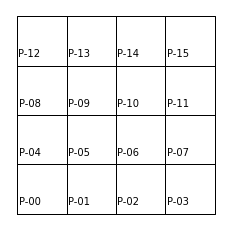

In [12]:
ax = gdf.plot(facecolor='w', edgecolor='k')
[plt.text(x, y, t, 
          verticalalignment='center',
          horizontalalignment='center') for x, y, t in zip(
         [p.centroid.x-.25 for p in polys],
         [p.centroid.y-.25 for p in polys],
         [i for i in gdf['id']])]
ax.set_axis_off()
plt.show()

In [13]:
# do a regular 3x3 lattice and draw it here
w = weights.contiguity.Rook.from_dataframe(gdf)
w.neighbors

{0: [1, 4],
 1: [0, 2, 5],
 2: [1, 3, 6],
 3: [2, 7],
 4: [0, 8, 5],
 5: [1, 4, 6, 9],
 6: [2, 10, 5, 7],
 7: [3, 11, 6],
 8: [9, 4, 12],
 9: [8, 10, 13, 5],
 10: [9, 11, 6, 14],
 11: [10, 7, 15],
 12: [8, 13],
 13: [9, 12, 14],
 14: [10, 13, 15],
 15: [11, 14]}

In [14]:
w.full()

(array([[0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0

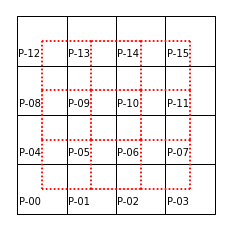

In [15]:
f,ax = plt.subplots(1,1, subplot_kw=dict(aspect='equal'))
w.plot(gdf, edge_kws=dict(color='r', linestyle=':'), ax =ax)
gdf.plot(facecolor='w', edgecolor='k', ax=ax)
[ax.text(x, y, t, 
          verticalalignment='center',
          horizontalalignment='center') for x, y, t in zip(
         [p.centroid.x-.25 for p in polys],
         [p.centroid.y-.25 for p in polys],
         [i for i in gdf['id']])]
plt.gca().set_axis_off()

In [16]:
pd.DataFrame(*w.full()).astype(int)

0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15
0    0   1   0   0   1   0   0   0   0   0   0   0   0   0   0   0
1    1   0   1   0   0   1   0   0   0   0   0   0   0   0   0   0
2    0   1   0   1   0   0   1   0   0   0   0   0   0   0   0   0
3    0   0   1   0   0   0   0   1   0   0   0   0   0   0   0   0
4    1   0   0   0   0   1   0   0   1   0   0   0   0   0   0   0
5    0   1   0   0   1   0   1   0   0   1   0   0   0   0   0   0
6    0   0   1   0   0   1   0   1   0   0   1   0   0   0   0   0
7    0   0   0   1   0   0   1   0   0   0   0   1   0   0   0   0
8    0   0   0   0   1   0   0   0   0   1   0   0   1   0   0   0
9    0   0   0   0   0   1   0   0   1   0   1   0   0   1   0   0
10   0   0   0   0   0   0   1   0   0   1   0   1   0   0   1   0
11   0   0   0   0   0   0   0   1   0   0   1   0   0   0   0   1
12   0   0   0   0   0   0   0   0   1   0   0   0   0   1   0   0
13   0   0   0   0   0   0   0   0   0   1   0   0   1   0   1   0
14   0   0   0   0   0   0   0   0   0   0   1   0   0   1   0   1
15   0   0   0   0   0   0   0   0   0   0   0   1   0   0   1   0

As you can see from the matrix above, most entries are zero. In fact out of all of the possible $16^2=256$ linkages that there could be in this matrix, there are only 48:

In [12]:
w.nonzero

48

Thus, we can save a significant amount of memory and lose no information by storing these sparse representations, which only record the non-zero values. 

In [17]:
# do a regular 3x3 lattice and draw it here
w = weights.contiguity.Queen.from_dataframe(gdf)
w.neighbors

{0: [1, 4, 5],
 1: [0, 2, 4, 5, 6],
 2: [1, 3, 5, 6, 7],
 3: [2, 6, 7],
 4: [0, 1, 5, 8, 9],
 5: [0, 1, 2, 4, 6, 8, 9, 10],
 6: [1, 2, 3, 5, 7, 9, 10, 11],
 7: [2, 3, 6, 10, 11],
 8: [4, 5, 9, 12, 13],
 9: [4, 5, 6, 8, 10, 12, 13, 14],
 10: [5, 6, 7, 9, 11, 13, 14, 15],
 11: [6, 7, 10, 14, 15],
 12: [8, 9, 13],
 13: [8, 9, 10, 12, 14],
 14: [9, 10, 11, 13, 15],
 15: [10, 11, 14]}

In addition to this neighbors representation, we can also express the graph visually, as done before:

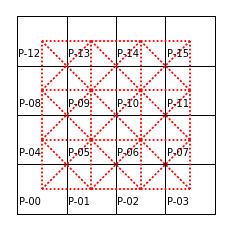

In [18]:
f,ax = plt.subplots(1,1, subplot_kw=dict(aspect='equal'))
w.plot(gdf, edge_kws=dict(color='r', linestyle=':'), ax =ax)
gdf.plot(facecolor='w', edgecolor='k', ax=ax)
[ax.text(x, y, t, 
          verticalalignment='center',
          horizontalalignment='center') for x, y, t in zip(
         [p.centroid.x-.25 for p in polys],
         [p.centroid.y-.25 for p in polys],
         [i for i in gdf['id']])]
plt.gca().set_axis_off()

Like the `neighbors` dictionary encodes the contiguity relations, the `weights` dictionary encodes the strength of the link connecting the focal to each neighbor. 

In [15]:
w.weights

{0: [1.0, 1.0, 1.0],
 1: [1.0, 1.0, 1.0, 1.0, 1.0],
 2: [1.0, 1.0, 1.0, 1.0, 1.0],
 3: [1.0, 1.0, 1.0],
 4: [1.0, 1.0, 1.0, 1.0, 1.0],
 5: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 6: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 7: [1.0, 1.0, 1.0, 1.0, 1.0],
 8: [1.0, 1.0, 1.0, 1.0, 1.0],
 9: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 10: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 11: [1.0, 1.0, 1.0, 1.0, 1.0],
 12: [1.0, 1.0, 1.0],
 13: [1.0, 1.0, 1.0, 1.0, 1.0],
 14: [1.0, 1.0, 1.0, 1.0, 1.0],
 15: [1.0, 1.0, 1.0]}

It is important to note that the `weights` and `neighbors` are aligned with one another; for each observation, its first neighbor in `neighbors` has the first weight in its `weights` entry. This will be important when we examine distance based weights further
on, when observations will have different weights. 

The `cardinalities` attribute reports the number of neighbors for each observation:

In [16]:
w.cardinalities

{0: 3,
 1: 5,
 2: 5,
 3: 3,
 4: 5,
 5: 8,
 6: 8,
 7: 5,
 8: 5,
 9: 8,
 10: 8,
 11: 5,
 12: 3,
 13: 5,
 14: 5,
 15: 3}

The `histogram` attribute provides an overview of the distribution of these cardinalities:

In [17]:
w.histogram

[(3, 4), (4, 0), (5, 8), (6, 0), (7, 0), (8, 4)]

We can obtain a quick visual representation by converting the cardinalities
into a `pandas.Series` and creating a histogram:

In [18]:
type(w.cardinalities)

dict

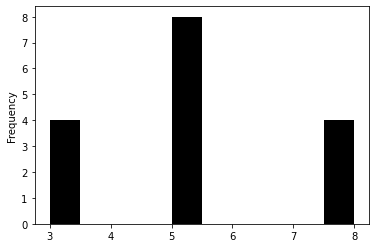

In [19]:
pd.Series(w.cardinalities).plot.hist(color='k');

The `cardinalities` and `histogram` attributes help quickly spot asymmetries in
the number of neighbors. Here we see that there are four corner
observations with three neighbors, and the four central observation has eight neighbors. 

By convention, an **ordered** pair of contiguous observations constitutes a *join*
represented by a non-zero weight in a $W$. The attribute `s0` records the number
of joins.

In [20]:
w.s0

84.0

The `pct_nonzero` attribute provides a measure of the density (compliment of
sparsity) of the spatial weights matrix (if we had it stored explicitly, which
we don't):

In [21]:
w.pct_nonzero

32.8125

In [22]:
w.n

16

#### Spatial Weights from real-world data

PySAL supports the construction of spatial weights from a number of commonly used spatial data formats. Here we demonstrate this
functionality for the case of Singapore Social Economic data 2017 aggregated by subzone. 
Note that shapefiles do not explicitly store topological information. PySAL uses efficient spatial indexing structures to extract spatial weights.

In [19]:
sz = gpd.read_file('Data/MP14_Subzone_SE_2017.shp')
wq = weights.contiguity.Queen.from_dataframe(sz)

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There are 3 islands with ids: 26, 263, 289.
  warnings.warn(message)


In [20]:
len(wq.islands)

3

Like before, we can visualize the adjacency relationships, but they are much more difficult to see without showing a closer detail.

(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

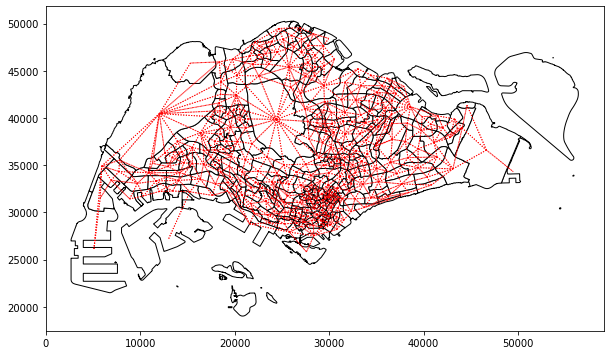

In [21]:
ax = sz.plot(edgecolor='k', facecolor='w',figsize=(10,10))
wq.plot(sz, ax=ax, 
        edge_kws=dict(color='r', linestyle=':', linewidth=1),
        node_kws=dict(marker=''))
# ax.set_axis_off()

So, showing more detail, we can get a glimpse of the complicated structure of the contiguity relationships between tracts in the center city:

(20000.0, 30000.0, 35000.0, 40000.0)

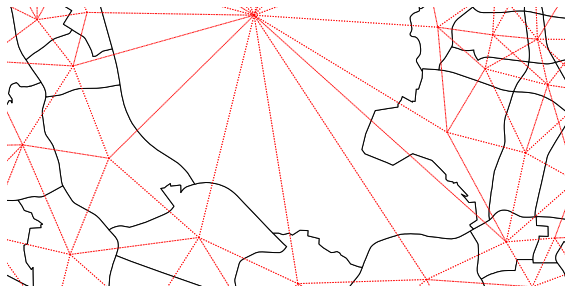

In [22]:
ax = sz.plot(edgecolor='k', facecolor='w',figsize=(10,10))
wq.plot(sz, ax=ax, 
        edge_kws=dict(color='r', linestyle=':', linewidth=1),
        node_kws=dict(marker=''))
ax.set_axis_off()
ax.axis([20000,  30000, 35000, 40000])

#### Interactive Map

In [26]:
# !pip install folium

Defaulting to user installation because normal site-packages is not writeable


C:\PROGRA~1\QGIS32~1.0\apps\Python39\lib\threading.py:896: ResourceWarning: unclosed file <_io.BufferedWriter name=5>
  del self._target, self._args, self._kwargs
C:\PROGRA~1\QGIS32~1.0\apps\Python39\lib\threading.py:896: ResourceWarning: unclosed file <_io.BufferedReader name=6>
  del self._target, self._args, self._kwargs
C:\PROGRA~1\QGIS32~1.0\apps\Python39\lib\threading.py:896: ResourceWarning: unclosed file <_io.BufferedReader name=7>
  del self._target, self._args, self._kwargs


In [23]:
import folium

In [24]:
mapa = folium.Map(width=600, height=400, zoom_start=12, detectRetina=True,
            max_zoom=18,
            min_zoom=11,
              location=[1.3, 103.8], tiles='https://maps-{s}.onemap.sg/v3/Default/{z}/{x}/{y}.png',
                 attr= '<img src="https://www.onemap.gov.sg/docs/maps/images/oneMap64-01.png" style="height:20px;width:20px;"/> OneMap | Map data &copy; contributors, <a href="http://SLA.gov.sg">Singapore Land Authority</a>')

In [25]:
mapa

In [30]:
sz.columns

Index(['SUBZONE_N', 'SUBZONE_C', 'PLN_AREA_N', 'PLN_AREA_C', 'REGION_N',
       'REGION_C', 'BET0TO2', 'BET3TO4', 'BET5TO6', 'BET7TO9',
       ...
       'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'geometry'],
      dtype='object', length=114)

In [26]:
sz_4326 = sz.to_crs(4326)
for _, r in sz_4326.iterrows():
    sim_geo = gpd.GeoSeries(r['geometry'])
#     sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    folium.Popup(r['SUBZONE_N']).add_to(geo_j)
    geo_j.add_to(mapa)
mapa

In [32]:
print(wq.n)
print(wq.pct_nonzero)

321
1.8769227783115459


First we have a larger number of spatial units, and the cardinalities are different from the meshgrid. 

In [33]:
s = pd.Series(wq.cardinalities)

In [34]:
s.unique().shape

(15,)

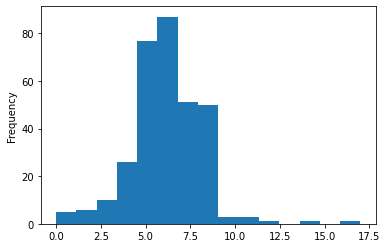

In [35]:
s.plot.hist(bins=s.unique().shape[0]);

There is also a function to create the rook weights for the same dataframe:

1.6207140846847372


C:\Users\user\AppData\Roaming\Python\Python39\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There are 3 islands with ids: 26, 263, 289.
  warnings.warn(message)


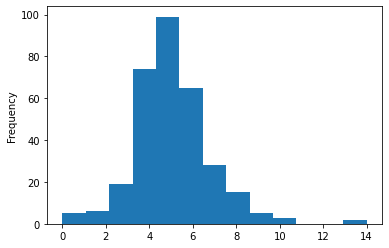

In [27]:
wr = weights.contiguity.Rook.from_dataframe(sz)
print(wr.pct_nonzero)
s = pd.Series(wr.cardinalities)
s.plot.hist(bins=s.unique().shape[0]);

The cardinality histogram shifts downward due to the increasing sparsity of the
weights for the rook case relative to the queen criterion.


### Distance Based Weights

In addition to contiguity, we can also define neighbor relations as a function of
the distance between all pairs of observations are required. These is a kernel function which uses the proximity information to model proximity as a smooth function of distance. PySAL implements a family of
distance functions. Here we illustrate a selection beginning with the notion
of *nearest neighbor* weights.

#### K-Nearest Neighbor weights

The first type of distance based weights defines the neighbor set of a
particular observation as containing its nearest $k$ observations, where the
user specifies the value of $k$. 

In [28]:
wk4 = weights.distance.KNN.from_dataframe(sz, k=4)

The centroids are attributes of the polygon shapes that PySAL calculates from
the spatial information stored in the `GeoDataFrame`. Since we are dealing with
polygons in this case, PySAL uses inter-centroid distances to determine the
$k$ nearest observations to each polygon. 

The k-nearest neighbor weights displays no island problem:

In [29]:
wk4.islands

[]

In [30]:
wk4.neighbors

{0: [11, 2, 36, 5],
 1: [35, 14, 13, 8],
 2: [36, 0, 33, 37],
 3: [5, 12, 4, 17],
 4: [3, 9, 5, 12],
 5: [3, 12, 4, 36],
 6: [8, 42, 16, 38],
 7: [9, 4, 10, 83],
 8: [6, 13, 38, 16],
 9: [4, 7, 3, 12],
 10: [7, 22, 30, 9],
 11: [0, 24, 17, 2],
 12: [3, 5, 17, 4],
 13: [14, 8, 21, 1],
 14: [13, 21, 1, 15],
 15: [43, 14, 87, 59],
 16: [6, 8, 24, 23],
 17: [12, 81, 5, 3],
 18: [45, 89, 20, 65],
 19: [87, 20, 15, 43],
 20: [19, 40, 18, 65],
 21: [14, 49, 13, 1],
 22: [10, 66, 82, 83],
 23: [24, 85, 88, 47],
 24: [23, 11, 85, 16],
 25: [106, 107, 73, 105],
 26: [27, 89, 31, 40],
 27: [28, 32, 31, 34],
 28: [34, 29, 33, 42],
 29: [33, 36, 2, 37],
 30: [41, 10, 7, 37],
 31: [39, 35, 32, 1],
 32: [38, 35, 1, 8],
 33: [29, 36, 37, 2],
 34: [42, 29, 0, 2],
 35: [1, 32, 38, 8],
 36: [2, 37, 33, 5],
 37: [36, 33, 41, 2],
 38: [32, 8, 6, 35],
 39: [43, 31, 15, 1],
 40: [20, 19, 39, 43],
 41: [37, 33, 36, 30],
 42: [34, 6, 0, 38],
 43: [15, 39, 1, 14],
 44: [61, 101, 67, 129],
 45: [69, 18, 80, 65],

This is the same for the contiguity case above but, in the case of k-nearest neighbor weights, this is by construction. However, examination of the cardinality histogram for the k-nearest neighbor weights shows us
that each observation has the same number of neighbors:

In [31]:
wk4.histogram

[(4, 321)]

#### Kernel weights

Kernel weights are one of the most commonly-used kinds of distance weights. They reflect the case where similarity/spatial proximity is assumed to decay with distance, which reflect Tobler's first law
{cite}`Tobler1970computer` in a more direct way: observations that are close to a unit have larger
valued weights than more distant observations.

In [32]:
w_kernel = weights.distance.Kernel.from_dataframe(sz)

Like k-nearest neighbor weights, the Kernel weights are based on distances between observations. 
The value of the weights will be a function of two main options for
kernel weights: choice of kernel function; and the bandwidth. 

* The kernel funtion controls how distance between $i$ and $j$ is "modulated" to produce a
the weight that goes in $w_{ij}$. PySAL offers a large number
of functions that determine the shape of the distance
decay function. 

* The bandwidth specifies the distance from each focal unit over which
the kernel function is applied. For observations separated by distances larger
than the bandwidth, the weights are set to zero.

The default values for kernels are to use a triangular kernel with a bandwidth distance
equal to the maximum knn=2 distance
for all observations. The latter implies a so-called fixed bandwidth where all
observations use the same distance for the cut-off. We can inspect this from
the generated `W` object:

In [33]:
w_kernel.function

'triangular'

for the kernel function, and:

In [34]:
w_kernel.bandwidth[0:5]

array([[8330.61986974],
       [8330.61986974],
       [8330.61986974],
       [8330.61986974],
       [8330.61986974]])

In cases where the density of the observations varies over the study region,
an *adaptive* bandwidth -one which varies by observation and its
characteristics- can be preferred. 

Adaptive bandwidths are picked  using a K-nearest neighbor rule. A bandwidth for each observation is chosen such that, once the $k$-nearest observation is considered, all the remaining observations have zero weight.

For example, using a subset of tracts in our Singapore dataset, we can see that the centroids of each tract are not exactly regularly-spaced.

In [36]:
sz.describe()

BET0TO2      BET3TO4      BET5TO6      BET7TO9    BET10TO12  \
count   321.000000   321.000000   321.000000   321.000000   321.000000   
mean    365.077882   253.694704   268.504673   400.143302   410.872274   
std     598.118751   411.170585   417.543562   595.954946   604.045579   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%     121.000000    99.000000   102.000000   167.000000   164.000000   
75%     480.000000   320.000000   340.000000   549.000000   566.000000   
max    3591.000000  2366.000000  2482.000000  3835.000000  3840.000000   

         BET13TO14    BET15TO16    BET17TO19     BET20TO24     BET25TO29  ...  \
count   321.000000   321.000000   321.000000    321.000000    321.000000  ...   
mean    280.003115   299.962617   461.906542    823.971963    928.987539  ...   
std     416.002400   454.665789   717.514767   1329.892128   1414.929537  ...   
min       0.000000     0.000000     0.000000      0.000000      0.000000  ...   
25%       0.000000     0.000000     0.000000      0.000000      0.000000  ...   
50%     117.000000   117.000000   178.000000    295.000000    337.000000  ...   
75%     379.000000   409.000000   604.000000   1107.000000   1332.000000  ...   
max    2812.000000  3186.000000  5214.000000  11053.000000  11635.000000  ...   

                 L           M            N            O            P  \
count   321.000000   321.00000   321.000000   321.000000   321.000000   
mean    103.118380   507.82866   570.077882   431.009346   199.510903   
std     152.678272   693.02209   888.368401   659.252406   273.780639   
min       0.000000     0.00000     0.000000     0.000000     0.000000   
25%       0.000000     0.00000     0.000000     0.000000     0.000000   
50%      27.000000   213.00000   122.000000   134.000000   101.000000   
75%     166.000000   777.00000   866.000000   645.000000   324.000000   
max    1067.000000  4970.00000  7032.000000  5115.000000  1824.000000   

                 Q           R            S   VariableX     Ina_CPF_N  
count   321.000000  321.000000   321.000000  321.000000    321.000000  
mean    326.613707   25.520249   211.545171  642.925234   3805.619938  
std     490.275063   38.692301   308.833570  209.409469   4006.428052  
min       0.000000    0.000000     0.000000    0.000000      0.000000  
25%       0.000000    0.000000     0.000000  538.000000    679.000000  
50%     101.000000    0.000000    55.000000  668.000000   2699.000000  
75%     462.000000   42.000000   295.000000  798.000000   5812.000000  
max    3934.000000  264.000000  2172.000000  995.000000  26885.000000  

[8 rows x 99 columns]

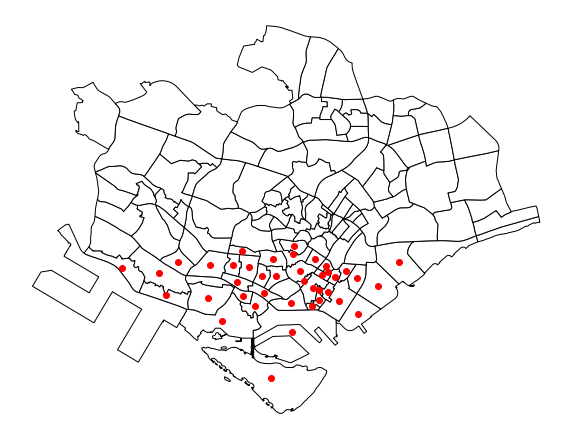

In [37]:
sz_central = sz.query("REGION_N == 'CENTRAL REGION'")
ax = sz_central.plot(facecolor='w', edgecolor='k',figsize=(10,10))
sz_central.head(40).centroid.plot(color='r', ax=ax)
ax.set_axis_off()

We can see that the adaptive bandwidth adjusts using fixed=false, and add k parameter

In [38]:
w_adaptive = weights.distance.Kernel.from_dataframe(sz_central, fixed=False, k=15)
w_adaptive.bandwidth

array([[1147.10193393],
       [1804.26351284],
       [1372.71450626],
       [1141.58625365],
       [1306.42736735],
       [1234.63932461],
       [1547.33561444],
       [1693.66052823],
       [1565.56488204],
       [1372.71450626],
       [2257.26669902],
       [1277.58294481],
       [1294.10584596],
       [1714.87849594],
       [1716.89436231],
       [1994.87266896],
       [1408.73162706],
       [1134.63738417],
       [3282.93404237],
       [2307.69481396],
       [2581.20808444],
       [1657.34456104],
       [2482.39564441],
       [1397.08081655],
       [1332.7554094 ],
       [3806.84668175],
       [2264.35558201],
       [1709.44243665],
       [2346.59056467],
       [2640.03474201],
       [2022.18531849],
       [1523.39361196],
       [1754.14850345],
       [1783.44821878],
       [1245.29889439],
       [1372.53166508],
       [1792.29442953],
       [2157.30992624],
       [2856.39507812],
       [1769.89897225],
       [1554.12159106],
       [2043.068

And, we can visualize what these kernels look like on the map, too, by focusing on an individual unit and showing how the distance decay attenuates the weight by grabbing the corresponding row of the full kernel matrix:

In [39]:
full_matrix, ids = w_adaptive.full() 

In [40]:
full_matrix[1]

array([0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.02043810e-01, 0.00000000e+00,
       4.77139851e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 6.15932790e-01, 6.44433504e-01, 3.50635995e-01,
       1.31165781e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 3.62276560e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.27713924e-01, 3.86177961e-01, 0.00000000e+00,
       0.00000000e+00, 6.93216463e-01, 0.00000000e+00, 0.00000000e+00,
       4.14965006e-01, 3.16945693e-01, 0.00000000e+00, 0.00000000e+00,
       9.99999901e-08, 3.81006310e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.27902118e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

[None, None]

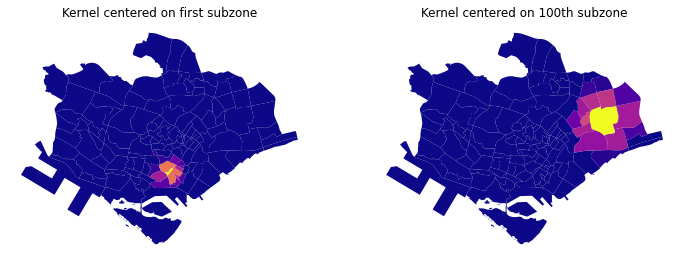

In [41]:
f,ax = plt.subplots(1,2,figsize=(12,6), subplot_kw=dict(aspect='equal'))
sz_central.assign(weight_0 = full_matrix[0]).plot("weight_0", cmap='plasma', ax=ax[0])
sz_central.assign(weight_15 = full_matrix[101]).plot("weight_15", cmap='plasma', ax=ax[1])
ax[0].set_title("Kernel centered on first subzone")
ax[1].set_title("Kernel centered on 100th subzone")
[ax_.set_axis_off() for ax_ in ax]

What the kernel looks like can be strongly affected by the structure of spatial proximity, so any part of the map can look quite different from any other part of the map. By imposing a clear distance decay over several of the neighbors of each observation,
kernel weights incorporate Tobler's law very explicitly. Often, this comes at the cost of
increased memory requirements, as every single pair of observations within the
bandwidth distance is considered:

In [106]:
w_kernel.pct_nonzero

31.7553206975864

#### Distance bands and hybrid Weights (Optional)

In some contexts, it makes sense to draw a circle around each observation and
consider as neighbors every other observation that falls within the circle.
In the GIS terminology, this is akin to drawing a buffer around each point and
performing a point-in-polygon operation that determines whether each of the
other observations are within the buffer. If they are, they are assigned a
weight of one in the spatial weights matrix, if not they receive a zero.

In [44]:
w_bdb = weights.distance.DistanceBand.from_dataframe(sz, 5000, binary=True)

This creates a binary distance weights where every other observation within
a distance of 5000m is considered neighbor.

Hybrid weights, also available in PySAL, are matrices that
offer a blend of the threshold and continuous distance weights by truncating the
neighbor pairs to those separated by less than some distance threshold.

Let us for instance calculate a hybrid matrix that combines inverse distance
weights up to a certain threshold and then truncate the weights to zero for
everyone else. For this example we will return to the small lattice example
covered in the beginning:

In [45]:
w_hy = weights.distance.DistanceBand.from_dataframe(sz, 5000, binary=False)

We can inspect the `weights` dictionary to see the weights, in this case, are
not 1 or 0 only, but there are values in-between:

In [46]:
w_hy.weights

{0: [0.0004046556941276823,
  0.002409535835852817,
  0.0010712991189699343,
  0.0008717621951643397,
  0.001398993915930461,
  0.0009434387477268602,
  0.0005056757111133053,
  0.0006387471458201851,
  0.0006295979424559867,
  0.0003608489985932328,
  0.00254278617129758,
  0.0010072486311089091,
  0.0004733792736673691,
  0.00037114934872773726,
  0.00028411458420110435,
  0.0007098584860265224,
  0.001102460922093298,
  0.00021215917994874415,
  0.0003945471154465826,
  0.0002794722590122479,
  0.0007448609009756215,
  0.0009318142584310766,
  0.00026227315224863036,
  0.0005168449765938386,
  0.000996873706326286,
  0.00042615022622860034,
  0.0002957675540472949,
  0.000494514568402188,
  0.0010981709076269375,
  0.001045343034067809,
  0.00042980068845142395,
  0.0015464276784487195,
  0.001013322992434715,
  0.0006413215238798052,
  0.0002772657886625551,
  0.0006715843831508618,
  0.0013460558747278727,
  0.0002787382250316414,
  0.00038079529161323656,
  0.0004795286004833172,

### Set Operations on Weights (Optional)

We can create new matrices by *combining* different existing ones. This is useful in contexts where a
single neighborhood rule has flaws or when theory or other guiding principles
point in directions that require combining more than a single criterion.

#### Editing/connecting disconnected observations

In [47]:
disconnected_subzone = sz.iloc[[26]] # wq has three isolated areas 26, 263, 289

As we have seen above, this tract *does* have neighbors:

In [48]:
wq[26]

{}

But, for this example, we will assume it does not and thus we find ourselves in the position of having to create additional neighboring units. This approach does not only apply in the context of islands. Sometimes, the process we are interested in may require that we manually edit the weights to better reflect connections we *know* exist.

We will connect the observation to its nearest neighbor. To do this, we can construct the KNN graph as we did above, but set `k=1`, so observations are only assigned to their nearest neighbor:

In [49]:
wk1 = weights.distance.KNN.from_dataframe(sz, k=1)

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 77 disconnected components.
  warnings.warn(message)


In this graph, all our observations are connected to one other observation by construction:

In [50]:
pd.Series(wk1.cardinalities).unique()

array([1], dtype=int64)

So is, of course, our tract of interest:

In [51]:
wk1.neighbors[26]

[27]

To connect it in our initial matrix, we need to create a copy of the `neighbors` dictionary and update the entry for `26`, including `27` as a neighbor. So, first we copy the neighbors:

In [52]:
neighbors = wq.neighbors.copy()

and then we change the entry for the island observation to include its
nearest neighbor (`102`) as well as update `102` to have `103` as a neighbor:

In [53]:
neighbors[26].append(27)
neighbors[27].append(26)

In [54]:
wk1.neighbors[263]

[291]

In [55]:
wk1.neighbors[289]

[308]

In [56]:
neighbors[263].append(291)
neighbors[291].append(263)
neighbors[289].append(308)
neighbors[308].append(289)

In [57]:
wq_new = weights.W(neighbors)

#### Using the `union` of matrices (optional)

A more elegant approach to the island problem makes use of PySAL's support for
*set theoretic operations* on PySAL weights:

In [54]:
w_fixed_sets = weights.set_operations.w_union(wq, wk1)

It is important to mention that this approach is not exactly the same.

### Block Weights (optional)

Block weights connect every observation in a data set that belongs to the same category in a list provided.

In [55]:
sz.columns

Index(['SUBZONE_N', 'SUBZONE_C', 'PLN_AREA_N', 'PLN_AREA_C', 'REGION_N',
       'REGION_C', 'BET0TO2', 'BET3TO4', 'BET5TO6', 'BET7TO9',
       ...
       'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'geometry'],
      dtype='object', length=114)

In [56]:
sz[['SUBZONE_N', 'PLN_AREA_N', 'REGION_N']].head()

SUBZONE_N     PLN_AREA_N        REGION_N
0  PEOPLE'S PARK         OUTRAM  CENTRAL REGION
1    BUKIT MERAH    BUKIT MERAH  CENTRAL REGION
2      CHINATOWN         OUTRAM  CENTRAL REGION
3        PHILLIP  DOWNTOWN CORE  CENTRAL REGION
4  RAFFLES PLACE  DOWNTOWN CORE  CENTRAL REGION

Every subzone has a unique (`SUBZONE_N`) and a PLAN_AREA_N, shared by all subzones in
the same plan area. 

In [57]:
w_bl = weights.util.block_weights(sz['PLN_AREA_N'].values, 
                                  ids=sz['SUBZONE_N'].values)

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 55 disconnected components.
 There are 10 islands with ids: 10, 22, 27, 30, 212, 230, 261, 265, 285, 289.
  warnings.warn(message)


As a check, let's consider the first two rows in the table above. If the block
weights command has worked out correctly, both should be neighbors:

In [58]:
w_bl.weights

{"PEOPLE'S PARK": [1.0, 1.0, 1.0],
 'BUKIT MERAH': [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'CHINATOWN': [1.0, 1.0, 1.0],
 'PHILLIP': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'RAFFLES PLACE': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'CHINA SQUARE': [1.0, 1.0, 1.0],
 'TIONG BAHRU': [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'BAYFRONT SUBZONE': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'TIONG BAHRU STATION': [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'CLIFFORD PIER': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'MARINA SOUTH': [],
 "PEARL'S HILL": [1.0, 1.0, 1.0],
 'BOAT QUAY': [1.0, 1.0],
 'HENDERSON HILL': [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],

### Visualizing weight set operations (optional)

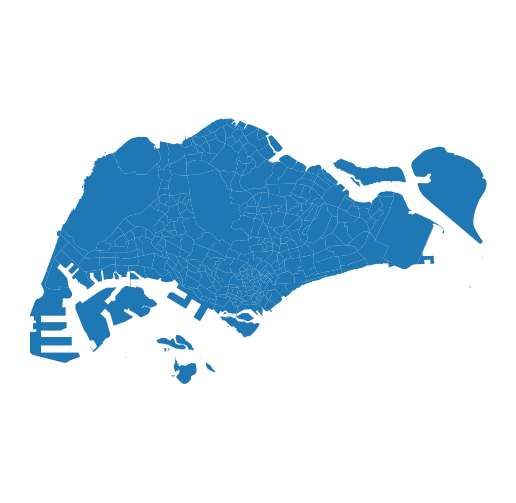

In [59]:
f, ax = plt.subplots(1, figsize=(9, 9))
sz.plot(ax=ax)
ax.set_axis_off()
plt.axis('equal')
plt.show()

We will contrast the connectivity structure for the three following types of spatial weights:

- Queen contiguity weights
- Block weights
- Combination of Block+Queen weights


Beginning with Queen weights:

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There are 3 islands with ids: 26, 263, 289.
  warnings.warn(message)


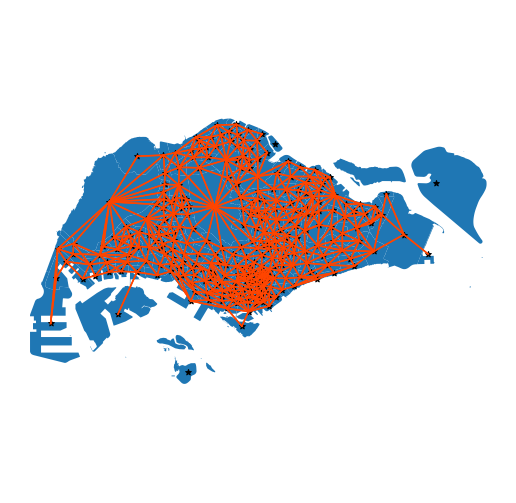

In [60]:
queen_sz = weights.contiguity.Queen.from_dataframe(sz)
f, ax = plt.subplots(1, figsize=(9, 9))
sz.plot(ax=ax)
queen_sz.plot(sz,edge_kws=dict(linewidth=1.5, color='orangered'), node_kws=dict(marker='*'),  ax=ax, )
ax.set_axis_off()
plt.axis('equal')
plt.show()

For the block weights

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 55 disconnected components.
 There are 10 islands with ids: 10, 22, 27, 30, 212, 230, 261, 265, 285, 289.
  warnings.warn(message)


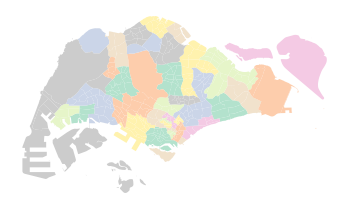

In [61]:
ax = sz.plot(column='PLN_AREA_N', categorical=True, cmap='Pastel2')
block_sz = weights.util.block_weights(sz['PLN_AREA_N'].values)
ax.set_axis_off()

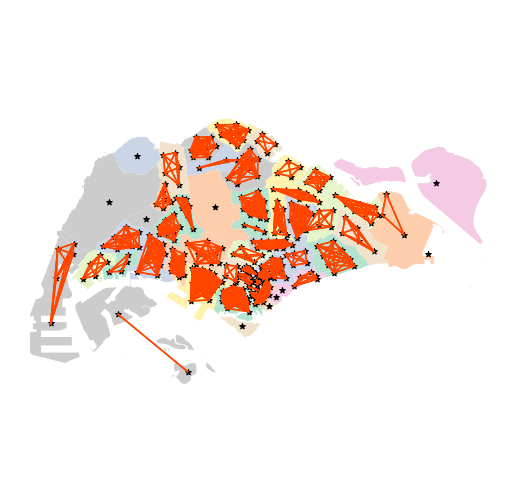

In [62]:
f, ax = plt.subplots(1, figsize=(9, 9))
sz.plot(column='PLN_AREA_N', categorical=True, 
        cmap='Pastel2', ax=ax)
block_sz.plot(sz, edge_kws=dict(linewidth=1.5, 
                                color='orangered'), 
                  node_kws=dict(marker='*'), ax=ax)
ax.set_axis_off()
plt.axis('equal')
plt.show()

Next, we construct the union of queen contiguity and block weights

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 289.
  warnings.warn(message)


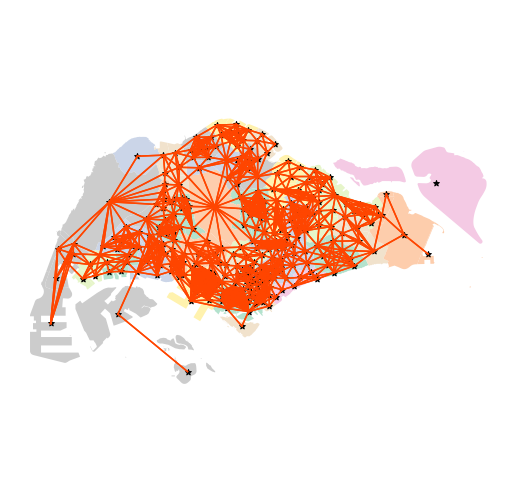

In [63]:
union_sz = weights.set_operations.w_union(block_sz, queen_sz)

f, ax = plt.subplots(1, figsize=(9, 9))
sz.plot(column='PLN_AREA_N', categorical=True, cmap='Pastel2', ax=ax)
union_sz.plot(sz, edge_kws=dict(linewidth=1.5, 
                                color='orangered'), 
              node_kws=dict(marker='*'), ax=ax)
ax.set_axis_off()
plt.axis('equal')
plt.show()

Finally, we compare the three neighbor graphs side by side:

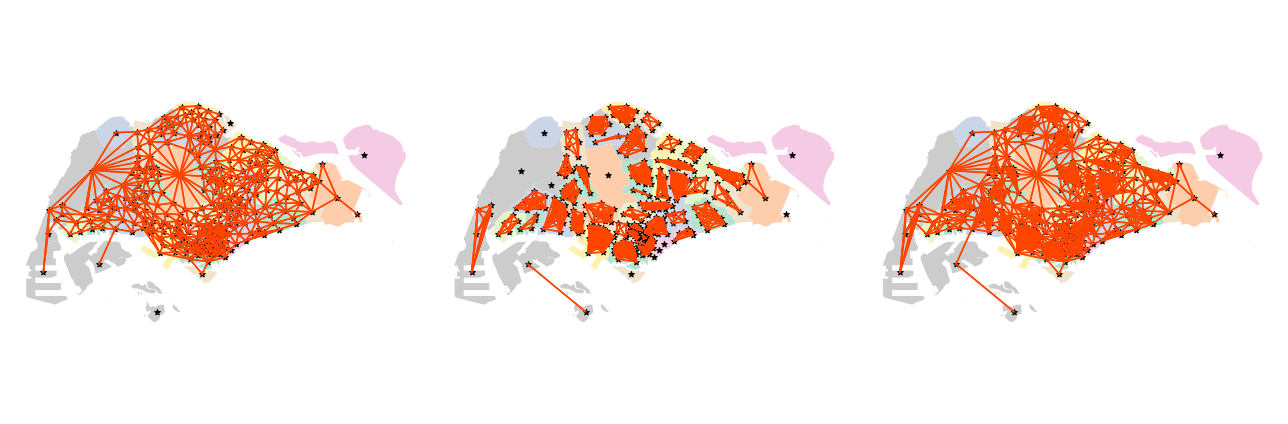

In [64]:
f, axs = plt.subplots(1, 3, figsize=(18, 6))

# Contiguity
ax = axs[0]
sz.plot(column='PLN_AREA_N', categorical=True, 
        cmap='Pastel2', ax=ax)
queen_sz.plot(sz, edge_kws=dict(linewidth=1.5, color='orangered'), 
              node_kws=dict(marker='*'), ax=ax)
ax.set_axis_off()
ax.set_xlabel('Queen')
ax.axis('equal')

# Block
ax = axs[1]
sz.plot(column='PLN_AREA_N', categorical=True, 
        cmap='Pastel2', ax=ax)
block_sz.plot(sz, edge_kws=dict(linewidth=1.5, color='orangered'), 
              node_kws=dict(marker='*'), ax=ax)
ax.set_axis_off()
ax.set_xlabel('Block weights')
ax.axis('equal')

# Union
ax = axs[2]
sz.plot(column='PLN_AREA_N', categorical=True, 
        cmap='Pastel2', ax=ax)
union_sz.plot(sz, edge_kws=dict(linewidth=1.5, color='orangered'), 
              node_kws=dict(marker='*'), ax=ax)
ax.set_axis_off()
ax.set_xlabel('Queen + Block')
plt.axis('equal')
f.tight_layout()
plt.show()

Focusing on the Queen and Block graphs, there are clear distinctions between the
connectivity structures. The Block graph is visually more dense in particular areas relative to the
Queen graph and this is borne out in their sparsity measures:

In [65]:
block_sz.pct_nonzero

2.267058743606914

In [66]:
queen_sz.pct_nonzero

1.8769227783115459

## Global Spatial Autocorrelation

In [58]:
from pysal.viz import splot
from splot.esda import plot_moran
from pysal.explore import esda
from pysal.lib import weights
from numpy.random import seed

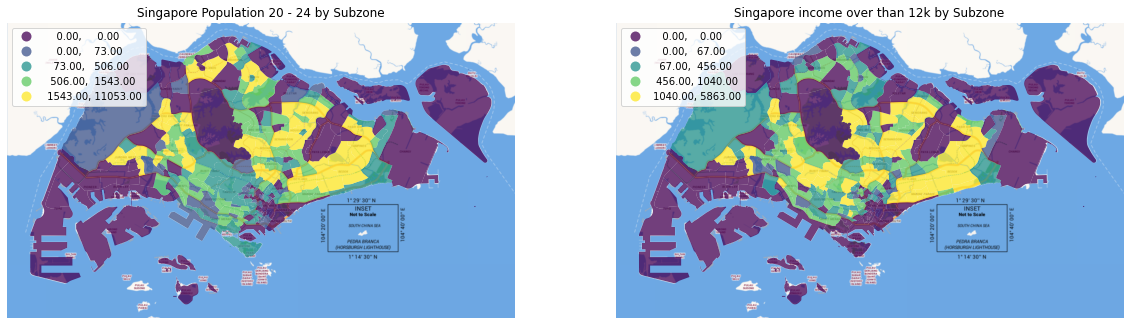

In [61]:
f, ax = plt.subplots(1, 2,figsize=(20, 20))
sz.plot(column='BET20TO24', 
        cmap='viridis',
        scheme='quantiles',
        k=5, 
        edgecolor='white', 
        linewidth=0., 
        alpha=0.75, 
        legend=True,
        legend_kwds={"loc": 2},
        ax=ax[0]
       )

contextily.add_basemap(ax[0], 
                       crs=sz.crs, 
                       source='https://maps-{s}.onemap.sg/v3/Default/{z}/{x}/{y}.png'
                      )

sz.plot(column='e12k_Over', 
        cmap='viridis',
        scheme='quantiles',
        k=5, 
        edgecolor='white', 
        linewidth=0., 
        alpha=0.75, 
        legend=True,
        legend_kwds={"loc": 2},
        ax=ax[1]
       )

contextily.add_basemap(ax[1], 
                       crs=sz.crs, 
                       source='https://maps-{s}.onemap.sg/v3/Default/{z}/{x}/{y}.png'
                      )

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[0].title.set_text('Singapore Population 20 - 24 by Subzone')
ax[1].title.set_text('Singapore income over than 12k by Subzone')

We will use eight nearest neighbors for the sake of the example. We also row-standardize them:

In [63]:
# Generate W from the GeoDataFrame
w = weights.KNN.from_dataframe(sz, k=8)
# Row-standardization
w.transform = 'R'

The map above appears to be positive spatial autocorrelation. However, the shape of geometries can also significantly distort our perception. By looking at the map above, for example, we can have an educated guess about the presence of spatial autocorrelation; but actually determining whether what we are seeing could have come from pure chance or not is usually easier said than done.

That is exactly the purpose of indicators of global spatial autocorrelation: to leverage the power of statistics to help us first summarize the spatial distribution of values present in a map, and second obtain a formal quantification of the departure from randomness. 

Before we can delve into the statistics, we need to understand a core building block: the spatial lag.

### Spatial Lag

The spatial lag operator is one of the most common and direct applications of spatial weights matrices ($W$'s) in spatial analysis. The mathematical definition is the product of $W$ and the vector of a given variable. Conceptually, the spatial lag captures the behavior of a variable in the immediate surroundings of each location; in that respect, it is akin to a local smoother of a variable. 

We can formally express it in matrix notation as:

$$
Y_{sl} = W Y
$$

or, in individual notation as:

$$
y_{sl-i} = \sum_j w_{ij} y_j
$$

where $w_{ij}$ is the cell in $W$ on the $i$-th row and $j$-th column, thus capturing the spatial relationship between observations $i$ and $j$. $y_{sl-i}$ thus captures the product of the values and weights of each observation other than $i$ in the dataset. Because non-neighbors receive a weight of zero, $y_{sl-i}$ really captures the product of values and weights for $i$'s neighbors. If $W$ is binary, this will amount to the sum of the values of $i$'s neighbors (useful in some contexts, such as studies of market potential); if $W$ is row standardized, a common transformation, $y_{sl-i}$ is bounded between zero and one; the spatial lag thus then becomes the average value of $Y$ in the neighborhood of each observation $i$. This latter meaning is the one that will enable our analysis of spatial autocorrelation below.


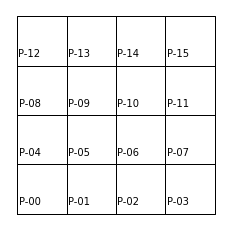

In [64]:
ax = gdf.plot(facecolor='w', edgecolor='k')
[plt.text(x, y, t, 
          verticalalignment='center',
          horizontalalignment='center') for x, y, t in zip(
         [p.centroid.x-.25 for p in polys],
         [p.centroid.y-.25 for p in polys],
         [i for i in gdf['id']])]
ax.set_axis_off()
plt.show()

Let's add one attribute to the dataframe gdf.

In [65]:
gdf['attr']= np.arange(0,16)
gdf

geometry    id  attr
0   POLYGON ((0.00000 0.00000, 1.00000 0.00000, 1....  P-00     0
1   POLYGON ((1.00000 0.00000, 2.00000 0.00000, 2....  P-01     1
2   POLYGON ((2.00000 0.00000, 3.00000 0.00000, 3....  P-02     2
3   POLYGON ((3.00000 0.00000, 4.00000 0.00000, 4....  P-03     3
4   POLYGON ((0.00000 1.00000, 1.00000 1.00000, 1....  P-04     4
5   POLYGON ((1.00000 1.00000, 2.00000 1.00000, 2....  P-05     5
6   POLYGON ((2.00000 1.00000, 3.00000 1.00000, 3....  P-06     6
7   POLYGON ((3.00000 1.00000, 4.00000 1.00000, 4....  P-07     7
8   POLYGON ((0.00000 2.00000, 1.00000 2.00000, 1....  P-08     8
9   POLYGON ((1.00000 2.00000, 2.00000 2.00000, 2....  P-09     9
10  POLYGON ((2.00000 2.00000, 3.00000 2.00000, 3....  P-10    10
11  POLYGON ((3.00000 2.00000, 4.00000 2.00000, 4....  P-11    11
12  POLYGON ((0.00000 3.00000, 1.00000 3.00000, 1....  P-12    12
13  POLYGON ((1.00000 3.00000, 2.00000 3.00000, 2....  P-13    13
14  POLYGON ((2.00000 3.00000, 3.00000 3.00000, 3....  P-14    14
15  POLYGON ((3.00000 3.00000, 4.00000 3.00000, 4....  P-15    15

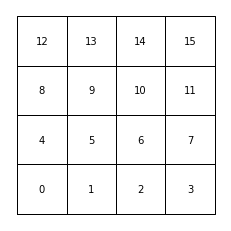

In [66]:
ax = gdf.plot(facecolor='w', edgecolor='k')
[plt.text(x, y, t, 
          verticalalignment='center',
          horizontalalignment='center') for x, y, t in zip(
         [p.centroid.x for p in polys],
         [p.centroid.y for p in polys],
         [i for i in gdf['attr']])]
ax.set_axis_off()
plt.show()

In [67]:
# do a regular 3x3 lattice and draw it here
w = weights.contiguity.Queen.from_dataframe(gdf)
w.neighbors

{0: [1, 4, 5],
 1: [0, 2, 4, 5, 6],
 2: [1, 3, 5, 6, 7],
 3: [2, 6, 7],
 4: [0, 1, 5, 8, 9],
 5: [0, 1, 2, 4, 6, 8, 9, 10],
 6: [1, 2, 3, 5, 7, 9, 10, 11],
 7: [2, 3, 6, 10, 11],
 8: [4, 5, 9, 12, 13],
 9: [4, 5, 6, 8, 10, 12, 13, 14],
 10: [5, 6, 7, 9, 11, 13, 14, 15],
 11: [6, 7, 10, 14, 15],
 12: [8, 9, 13],
 13: [8, 9, 10, 12, 14],
 14: [9, 10, 11, 13, 15],
 15: [10, 11, 14]}

In [68]:
w.weights

{0: [1.0, 1.0, 1.0],
 1: [1.0, 1.0, 1.0, 1.0, 1.0],
 2: [1.0, 1.0, 1.0, 1.0, 1.0],
 3: [1.0, 1.0, 1.0],
 4: [1.0, 1.0, 1.0, 1.0, 1.0],
 5: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 6: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 7: [1.0, 1.0, 1.0, 1.0, 1.0],
 8: [1.0, 1.0, 1.0, 1.0, 1.0],
 9: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 10: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 11: [1.0, 1.0, 1.0, 1.0, 1.0],
 12: [1.0, 1.0, 1.0],
 13: [1.0, 1.0, 1.0, 1.0, 1.0],
 14: [1.0, 1.0, 1.0, 1.0, 1.0],
 15: [1.0, 1.0, 1.0]}

In [69]:
w.to_adjlist()

focal  neighbor  weight
0       0         1     1.0
1       0         4     1.0
2       0         5     1.0
3       1         0     1.0
4       1         2     1.0
..    ...       ...     ...
79     14        13     1.0
80     14        15     1.0
81     15        10     1.0
82     15        11     1.0
83     15        14     1.0

[84 rows x 3 columns]

In [70]:
w.full()

(array([[0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
        [0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0.],
        [0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0

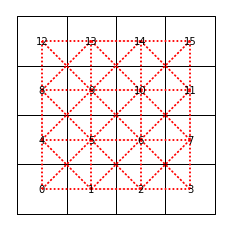

In [225]:
f,ax = plt.subplots(1,1, subplot_kw=dict(aspect='equal'))
w.plot(gdf, edge_kws=dict(color='r', linestyle=':'), ax =ax)
gdf.plot(facecolor='w', edgecolor='k', ax=ax)
[plt.text(x, y, t, 
          verticalalignment='center',
          horizontalalignment='center') for x, y, t in zip(
         [p.centroid.x for p in polys],
         [p.centroid.y for p in polys],
         [i for i in gdf['attr']])]
plt.gca().set_axis_off()

Get spatial lag of the attribute attr

In [71]:
w.full()[0]

array([[0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
       [0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0.],
       [0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0.],
       [0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,

In [72]:
spatial_lag_attr= np.matmul(w.full()[0],gdf.filter(['attr']).to_numpy())
spatial_lag_attr

array([[10.],
       [17.],
       [22.],
       [15.],
       [23.],
       [40.],
       [48.],
       [32.],
       [43.],
       [72.],
       [80.],
       [52.],
       [30.],
       [53.],
       [58.],
       [35.]])

In [73]:
gdf['spatial_lag_attr']=spatial_lag_attr

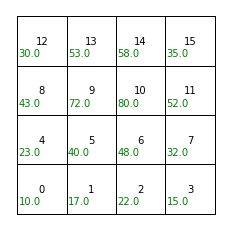

In [74]:
f,ax = plt.subplots(1,1, subplot_kw=dict(aspect='equal'))
# w.plot(gdf, edge_kws=dict(color='r', linestyle=':'), ax =ax)
gdf.plot(facecolor='w', edgecolor='k', ax=ax)
[plt.text(x, y, t, 
          verticalalignment='center',
          horizontalalignment='center') for x, y, t in zip(
         [p.centroid.x for p in polys],
         [p.centroid.y for p in polys],
         [i for i in gdf['attr']])]

[plt.text(x, y, sl, 
          verticalalignment='center',
          horizontalalignment='center',color="green") for x, y, sl in zip(
         [p.centroid.x -.25 for p in polys],
         [p.centroid.y-.25 for p in polys],
         [i for i in gdf['spatial_lag_attr']])]

plt.gca().set_axis_off()

In [75]:
# we can do the same with lag_spatial methods
weights.lag_spatial(w,gdf['attr'])


array([10., 17., 22., 15., 23., 40., 48., 32., 43., 72., 80., 52., 30.,
       53., 58., 35.])

### Moran Plot and Moran's I

The most commonly used statistic in this context is Moran's I {cite}`Moran1948`, which can be written as:

$$
I = \dfrac{n}{\sum_i\sum_j w_{ij}} \dfrac{\sum_i\sum_j w_{ij} \, z_i \, z_j}{\sum_i z_i^2}
$$

where $n$ is the  number of observations, $z_{i}$ is the standardized value of the variable of interest at location $i$, and $w_{ij}$ is the cell corresponding to the $i$-th row and $j$-th column of a $W$ spatial weights matrix.

In order to understand the intuition behind its math, it is useful to begin with a graphical interpretation: the Moran Plot. The Moran Plot is a way of visualizing a spatial dataset to explore the nature and strength of spatial autocorrelation. It is essentially a traditional scatter plot in which the variable of interest is displayed against its *spatial lag*. In order to be able to interpret values as above or below the mean, and their quantities in terms of standard deviations, the variable of interest is usually standardized by subtracting its mean and dividing it by its standard deviation:

In [78]:
# get the z score (normalize) of each subzone age between 20-24
sz['BET20TO24_std']=(sz['BET20TO24']-sz['BET20TO24'].mean())/sz['BET20TO24'].std()

# get spatial lag of each subzone 
# see wq_new defined above
sz['BET20TO24_lag'] =weights.lag_spatial(wq_new,sz['BET20TO24'])

# get the z score (normalize) of each subzone total residents
sz['BET20TO24_lag_std']=(sz['BET20TO24_lag']-sz['BET20TO24_lag'].mean())/sz['BET20TO24_lag'].std()

Creating a Moran Plot is very similar to creating any other scatter plot in Python:

Similarly, inference can also be carried out by relying on computational simulations that replicate several instances of spatial randomness using the values in the variable of interest, but shuffling their locations. In this case, the pseudo P-value computed suggests a clear departure from the hypothesis of no concentration.



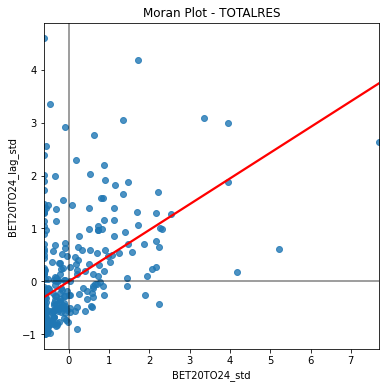

In [79]:
f, ax = plt.subplots(1, figsize=(6, 6))
sb.regplot(x='BET20TO24_std', y='BET20TO24_lag_std', 
                ci=None, data=sz, line_kws={'color':'r'})
ax.axvline(0, c='k', alpha=0.5)
ax.axhline(0, c='k', alpha=0.5)
ax.set_title('Moran Plot - TOTALRES')
plt.show()

The figure above displays the relationship between the standardized percentage to total residents and its spatial lag which, because the $wq$ used is row-standardized, can be interpreted as the average standardized residents in the neighborhood of each observation. In order to guide the interpretation of the plot, a linear fit is also included in the post, together with confidence intervals. This line represents the best linear fit to the scatter plot or, in other words, what is the best way to represent the relationship between the two variables as a straight line.

The plot displays a positive relationship between both variables. This is associated with the presence of positive spatial autocorrelation: similar values tend to be located close to each other. This means that the overall trend is for high values to be close to other high values, and for low values to be surrounded by other low values. This however does not mean that this is the only case in the dataset: there can of course be particular situations where high values are surrounded by low ones, and *vice versa*. But it means that, if we had to summarize the main pattern of the data in terms of how clustered similar values are, the best way would be to say they are positively correlated and, hence, clustered over space. 

The Moran Plot is an excellent tool to explore the data and get a good sense of how much values are clustered over space. However, because it is a graphical device, it is sometimes hard to condense its insights into a more concise way. For these cases, a good approach is to come up with a statistical measure that summarizes the figure. This is exactly what Moran's I, as formally expressed above, is meant to do.

Very much in the same way the mean summarizes a crucial element of the distribution of values in a non-spatial setting, so does Moran's I for a spatial dataset. Continuing the comparison, we can think of the mean as a single numerical value summarizing a histogram or a kernel density plot. Similarly, Moran's I captures much of the essence of the Moran Plot. In fact, there is a close connection between the two: the value of Moran's I corresponds with the slope of the linear fit overlayed on top of the Moran Plot.

In order to calculate Moran's I in our dataset, we can call a specific function in PySAL directly (before that, let us row standardized the `w` object again):

In [80]:
type(sz['BET20TO24'])

pandas.core.series.Series

In [82]:
moran = esda.moran.Moran(sz['BET20TO24'], wq_new)

The method `Moran` creates an object that contains much more information than the actual statistic. If we want to retrieve the value of the statistic, we can do it this way:

In [83]:
moran.I

0.30065487830289467

The other bit of information we will extract from Moran's I relates to statistical inference: how likely is the pattern we observe in the map and Moran's I captures in its value to be generated by an entirely random process? If we considered the same variable but shuffled its locations randomly, would we obtain a map with similar characteristics? To obtain insight into these questions, PySAL performs a simulation and returns a measure of certainty about how likely it is the pattern we observe in our dataset came from a spatially random process. This is summarized in the `p_sim` attribute:

In [84]:
moran.p_sim

0.001

The value is calculated as an empirical P-value that represents the proportion of realizations in the simulation under spatial randomness that are more extreme than the observed value. A small enough p-value associated with the Moran's I of a map allows to reject the hypothesis that the map is random. In other words, we can conclude that the map displays more spatial pattern than we would expect if the values had been randomly allocated to a locations.

That is a very low value, particularly considering it is actually the minimum value we could have obtained given the simulation behind it used 999 permutations (default in `PySAL`) and, by standard terms, it would be deemed statistically significant. We can elaborate a bit further on the intuition behind the value of `p_sim`. If we generated a large number of maps with the same values but randomly allocated over space, and calculated the Moran's I statistic for each of those maps, only 0.01% of them would display a larger (absolute) value than the one we obtain from the observed data, and the other 99.99% of the random maps would receive a smaller (absolute) value of Moran's I. If we remember again that the value of Moran's I can also be interpreted as the slope of the Moran Plot, what we have is that, in this case, the particular spatial arrangement of values over space we observe for the percentage of Leave votes is more concentrated than if we were to randomly shuffle the residents number among the map, hence the statistical significance. As a first step, the global autocorrelation analysis can teach us that observations do seem to be positively autocorrelated over space. Indeed, the overall spatial pattern in the Singapore population was: nearby subzones tended to have similair number of residents.

Thanks to the `splot` visualization module in PySAL, we can obtain a quick representation of the statistic that combines the Moran Plot (right) with a graphic of the empirical test that we carry out to obtain `p_sim` (left):

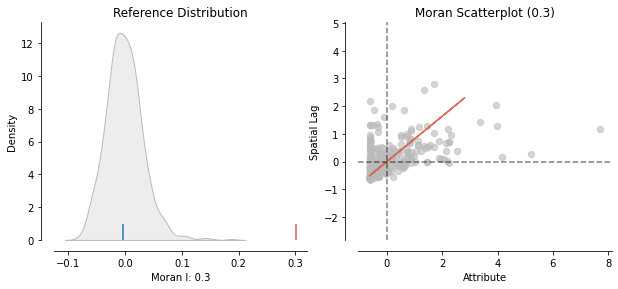

In [85]:
plot_moran(moran);

On the left panel we can see in gray the empirical distribution generated from simulating 999 random maps with the values of the `TOTALRES` variable and then calculating Moran's I for each of those maps. The blue rug signals the mean. In contrary, the red rug shows Moran's I calculated for the variable using the geography observed in the dataset. It is clear the value under the observed pattern is significantly higher than under randomness. This insight is confirmed on the right panel, where there is displayed an equivalent plot to the Moran Plot we created above.

### Geary's C

The contiguity ratio $c$, proposed by {cite}`Geary1954contiguity`, is given by:

$$
C = \dfrac{(n-1)}
          {2 \sum_i \sum_j w_{ij}} 
    \dfrac{\sum_i \sum_j w_{ij} (y_i - y_{j})^2}
          {\sum_i (y_i - \bar{y})^2}
$$

where $n$ is the number of observations, $w_{ij}$ is the cell in a binary matrix $W$ expressing whether $i$ and $j$ are neighbors ($w_{ij}=1$) or not ($w_{ij}=1$), $y_i$ is the $i$-th observation of the variable of interest, and $\bar{y}$ is its sample mean. When compared to Moran's I, it is apparent both measures put in relation the behavior of $Y$ within each observation's local neighborhood with that over the entire sample. However, there are also subtle differences. While Moran's I takes cross-products on the standardized values, Geary's C uses differences on the values without any standardization. 

Computationally, Geary's C is more demanding, but it can be easily computed using PySAL:

Which has a similar way of accessing its estimate:

In [86]:
geary = esda.geary.Geary(sz['BET20TO24'], wq)

In [87]:
geary.C

0.7344829084521565

Inference is performed in a similar way as with Moran. We can perform a simulation that allows us to draw an empirical distribution of the statistic under the null of spatial randomness, and then compare it with the statistic obtained when using the observed geographical distribution of the data. To access the pseudo p-value, calculated as in the Moran case, we can call `p_sim`:

In [88]:
geary.p_sim

0.002

In this case, Geary's C points in the same direction as Moran's I: there is clear indication that the statistic we calculate on the observed dataset is different from what would be expected in a situation of pure spatial randomness. Hence, from this analysis, we can also conclude spatial autocorrelation is present.

The value of Geary's C is always positive and lies between 0 and 2. A value of 1 is for the null model, which means no spatial autocorrelation. Value
between 0 and 1 means positive spatial autocorrelation, and value between 1 and 2 means negative spatial
autocorrelation. Moran's I is good at measuring the global spatial autocorrelation, but Geary's C is more
appropriate to measure local spatial autocorrelation.

### Getis and Ord's G

Originally proposed by {cite}`Getis1992analysis`, the $G$ is the global version of a family of statistics of spatial autocorrelation based on distance. The $G$ class of statistics is conceived for points, hence the use of a distance $W$, but it can also be applied to lattice data if a binary spatial weights matrix can be constructed. Additionally, it is designed for the study of positive variables with a natural origin. The $G$ can be expressed as follows:

$$
G(d) = \dfrac{ \sum_i \sum_j w_{ij}(d) \, y_i \, y_j }
             { \sum_i \sum_j y_i \, y_j }
$$

where $w_{ij}(d)$ is the binary weight assigned on the relationship between observations $i$ and $j$ following a distance band criterion. $G$ was originally proposed as a measure of concentration rather than of spatial autocorrelation. As such, it is well suited to test to what extent similar values (either high or low) tend to co-locate. In other words, the $G$ is a statistic of **positive** spatial autocorrelation. This is usually the interest in most Geographic Data Science applications. However, it is important to note that, because $G$ can be understood as a measure of the intensity with which $Y$ is concentrated, the statistic is not able to pick up cases of *negative* spatial autocorrelation.

To illustrate its computation, let us calculate a binary distance band $W$. To make sure every observation has at least one neighbor, we will use the `min_threshold_distance` method and project the dataset into the Ordnance Survey CRS (`EPSG` code 27700), expressed in meters:

In [89]:
pts = sz.centroid
xys = pd.DataFrame({'X': pts.x, 'Y': pts.y})
min_thr = weights.util.min_threshold_distance(xys)
min_thr

8330.532088256945

<AxesSubplot:>

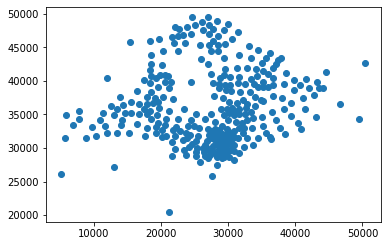

In [90]:
pts.plot()

For every local authority to have a neighbor, the distance band needs to at least be about 8330 m. This information can then be passed to the `DistanceBand` constructor:

In [91]:
w_sz = weights.DistanceBand.from_dataframe(sz, min_thr)

At this point, we are ready to calculate the global $G$ statistic:

In [92]:
gao = esda.getisord.G(sz['BET20TO24'], w_sz)

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\esda\getisord.py:164: RuntimeWarning: overflow encountered in longlong_scalars
  EG2DEN = ((sum(y) ** 2 - sum(y2)) ** 2) * n * (n - 1) * (n - 2) * (n - 3)


Access to the statistic (`gao.G`) and additional attributes can be gained in the same way as with the previous statistics:

In [93]:
print("Getis & Ord G: %.3f | Pseudo P-value: %.3f"%(gao.G, gao.p_sim))

Getis & Ord G: 0.325 | Pseudo P-value: 0.354


Think about why Moran'I is significant but Getis' G is not.

## Local Spatial Autocorrelation

The global measures of spatial autocorrelation are "whole map" statistics, meaning that the single statistic pertains to the complete data set. In other words, global autocorrelation statistics allow us to detect clustering in a geographically referenced dataset. For example, Moran's I is good tool to summarize a dataset into a single value that informs about its degree of geographical clustering. 

However, it is not an appropriate measure to identify areas within the map where specific types of values (e.g. high, low) are located. In other words, Moran's I can tell us values are clustered overall, but it will not inform us about where the clusters are. 

For that purpose, we need to use a local measure of spatial autocorrelation. Local measures consider each single observation and operate on them, as opposed to on the overall dataset, as global measures do. Because of that, they are not good at summarizing a map, but they allow to obtain further insights about interesting geographical subsets of the data. In this section, we consider Local Indicators of Spatial Association (LISAs) {cite}Anselin1995local, a local counter-part of global measures like Moran's I.

In [321]:
sz.columns

Index(['SUBZONE_N', 'SUBZONE_C', 'PLN_AREA_N', 'PLN_AREA_C', 'REGION_N',
       'REGION_C', 'BET0TO2', 'BET3TO4', 'BET5TO6', 'BET7TO9',
       ...
       'Q', 'R', 'S', 'T', 'U', 'V', 'geometry', 'TOTALRES_std',
       'TOTALRES_lag', 'TOTALRES_lag_std'],
      dtype='object', length=117)

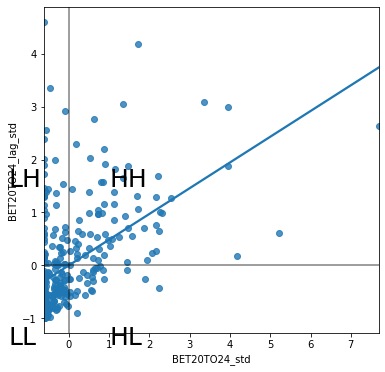

In [95]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))

# Plot values
sb.regplot(x='BET20TO24_std', y='BET20TO24_lag_std', data=sz, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Add text labels for each quadrant
plt.text(1, 1.5, "HH", fontsize=25)
plt.text(1, -1.5, "HL", fontsize=25)
plt.text(-1.5, 1.5, "LH", fontsize=25)
plt.text(-1.5, -1.5, "LL", fontsize=25)
# Display
plt.show()

We divide a Moran Plot in four quadrants, depending on whether a given area displays a value above the mean (high) or below (low), and how its spatial lag behaves:

* High-high (HH)
* Low-high (LH)
* Low-low (LL)
* High-low (HL)

### Local Moran's I

So far we have classified each observation in the dataset depending on its value and that of its neighbors. This is only half way into identifying areas of unusual concentration of values. To know whether each of the locations is a *statistically significant* cluster of a given kind, we again need to compare it with what we would expect if the data were allocated in a completely random way. After all, by definition, every observation will be of one kind of another, based on the comparison above. However, what we are interested in is whether the strength with which the values are concentrated is unusually high.

This is exactly what LISAs are designed to do. A more detailed description of their statistical underpinnings is beyond the scope in this context, but we will provide some intuition about how they work. The core idea is to identify cases in which the comparison between the value of an observation and the average of its neighbors is either more similar (HH, LL) or dissimilar (HL, LH) than we would expect from pure chance. The mechanism to do this is similar to the one in the global Moran's I, but applied in this case to each observation, resulting then in as many statistics as original observations. The formal representation of the statistic can be written as:

$$
I_i = \dfrac{z_i}{m_2} \displaystyle\sum_j w_{ij} z_j \; ; \; m_2 = \dfrac{\sum_i z_i^2}{n}
$$

where $m_2$ is the second moment (variance) of the distribution of values in the data, $z_i = y_i - \bar{y}$, $w_{i,j}$ is the spatial weight for the pair of observations $i$ and $j$, and $n$ is the number of observations.

LISAs are widely used in many fields to identify clusters of values in space. They are a very useful tool that can quickly return areas in which values are concentrated and provide suggestive evidence about the processes that might be at work.


In [96]:
# Generate W from the GeoDataFrame
w = weights.distance.KNN.from_dataframe(sz, k=8)
# Row-standardization
w.transform = 'R'

In [97]:
lisa = esda.moran.Moran_Local(sz['BET20TO24'], w)

All we need to pass is the variable of interest -proportion of Leave votes in this context- and the spatial weights that describes the neighborhood relations between the different areas that make up the dataset. This creates a LISA object that has a number of attributes of interest. The local indicators themselves are in the `Is` attribute and we can get a sense of their distribution using `seaborn`:

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

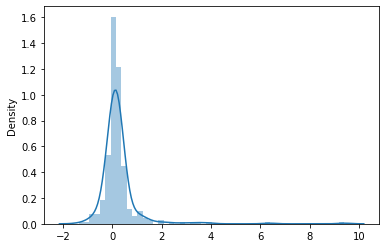

In [98]:
sb.distplot(lisa.Is)

Here it is important to keep in mind that the high positive values arise from value similarity in space, and this can be due to either high values being next to high values *or* low values next to low values. The local $I_i$ values themselves cannot distinguish between these two.

The values in the left tail of the density represent locations displaying negative spatial association. There are also two forms, a high value surrounded by low values, or a low value surrounded by high valued neighboring observations. And, again, the  $I_i$ value cannot distinguish between the two cases.

Because of their very nature, looking at the numerical result of LISAs is not always the most useful way to exploit all the information they can provide. Remember we are calculating a statistic for every single observation in the data so, if we have many of them, it will be difficult to extract any meaningful pattern. In this context, a choropleth can help. At first glance, this may seem to suggest that a map of the $I_i$  values would be a useful way to visualize the spatial distribution:

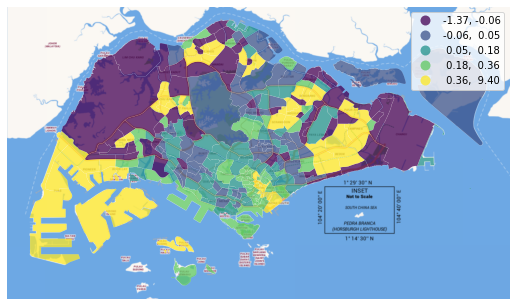

In [99]:
f, ax = plt.subplots(1, figsize=(9,9))
sz['Is'] = lisa.Is
sz.plot(column='Is', cmap='viridis', scheme='quantiles',
        k=5, edgecolor='white', linewidth=0.1, alpha=0.75, legend=True,ax=ax);

contextily.add_basemap(ax, 
                       crs=sz.crs, 
                       source='https://maps-{s}.onemap.sg/v3/Default/{z}/{x}/{y}.png'
                      )
ax.set_axis_off()

However, this does not inform us in any way about what type of spatial correlation each area is experiencing. Also, we know that values around zero will not be statistically significant. Which ones are thus significant and non-significant from a statistical point of view? In other words, which ones can be considered statistical clusters and which ones noise? To answer these questions, we need to bring in additional information that we have obtained when calculating the LISA statistics. Let us first build a four-plot figure that brings all these different perspectives together:

In [100]:
from matplotlib import colors

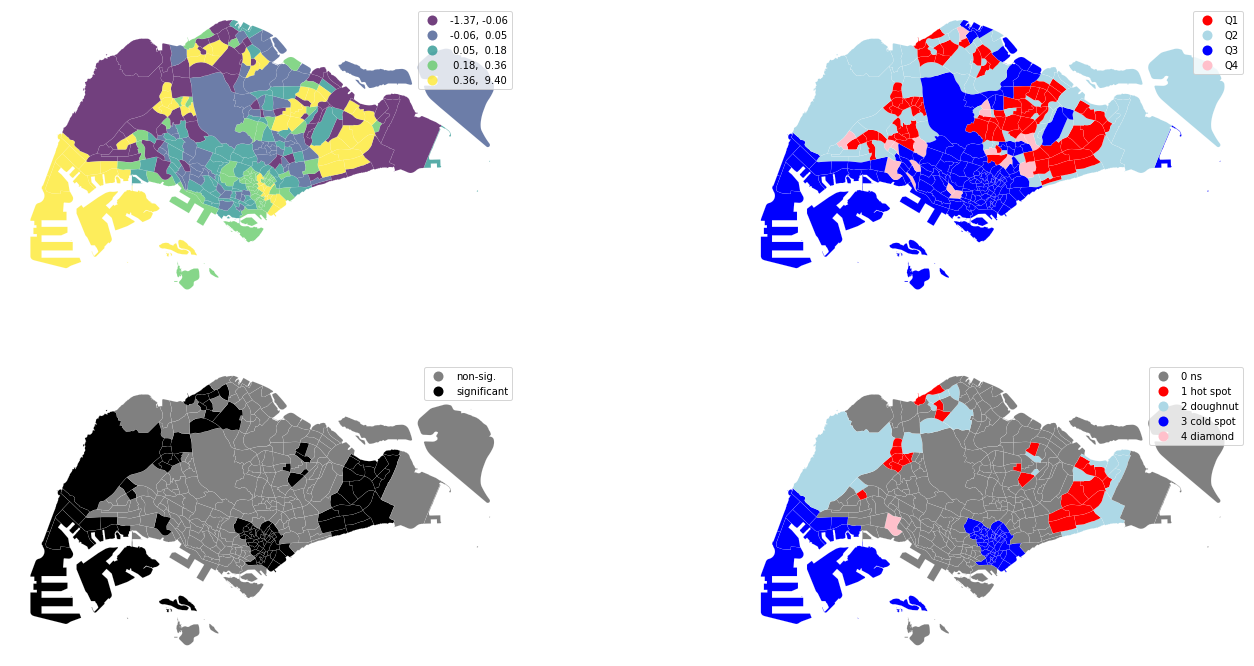

In [101]:
# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(24, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()

                    # Subplot 1 #
ax = axs[0]
sz.plot(column='Is', cmap='viridis', scheme='quantiles',
        k=5, edgecolor='white', linewidth=0.1, alpha=0.75, legend=True, ax=ax)
ax.set_aspect('equal')
ax.set_axis_off()

                    # Subplot 2 #
ax = axs[1]
q_labels = ['Q1', 'Q2', 'Q3', 'Q4']
labels = [q_labels[i-1] for i in lisa.q]
hmap = colors.ListedColormap([ 'red', 'lightblue', 'blue', 'pink'])
sz.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)

ax.set_aspect('equal')
ax.set_axis_off()

                    # Subplot 3 #

ax = axs[2]
sig = 1 * (lisa.p_sim < 0.05)
hmap = colors.ListedColormap(['grey','black'])
labels = ['non-sig.', 'significant'] 
labels = [labels[i] for i in sig]
sz.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)

ax.set_aspect('equal')
ax.set_axis_off()
                            
                    # Subplot 4 #
ax = axs[3]
hotspot = 1 * (sig * lisa.q==1)
coldspot = 3 * (sig * lisa.q==3)
doughnut = 2 * (sig * lisa.q==2)
diamond = 4 * (sig * lisa.q==4)
spots = hotspot + coldspot + doughnut + diamond
spot_labels = [ '0 ns', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
labels = [spot_labels[i] for i in spots]
hmap = colors.ListedColormap([ 'grey', 'red', 'lightblue', 'blue', 'pink'])


sz.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)

ax.set_aspect('equal')
ax.set_axis_off()


# Display the figure
plt.show()

The figure in the upper-left replicates our first map above. The green and yellow locations have the largest values for the local statistics, yet this does not distinguish between positive association of low support for the Brexit vote and positive association of high support for Brexit.

To distinguish between these two cases, the map in the upper-right shows the location of the LISA statistic in the quadrant of the Moran Scatter plot, which is recorded in the `q` attribute:


In [102]:
lisa.q[:10]

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

The correspondence between the numbers in the `q` attribute and the actual quadrants is as follows:

* 1: HH
* 2: LH
* 3: LL
* 4: HL



Overall, we can obtain counts of areas in each quadrant:

In [103]:
counts = [(j,(lisa.q==j).sum()) for j in range(1,5)]
counts

[(1, 77), (2, 72), (3, 155), (4, 17)]

Showing that the high-high (1), and low-low (3), values are predominant.

Care must be taken, however, in the interpretation of these first two maps, as the underlying statistical significance of the local values has not been considered.

Instead, what is typically done is to create a map, a cluster map as it is usually called, that extracts the significant observations (those that are highly unlikely to have come from pure chance) and plots them with a specific color depending on their quadrant category.

All of the needed pieces are contained inside the `lisa` object we have created above. But, to make the map making more straightforward, it is convenient to pull them out and insert them in the main data table:

In [104]:
sig = 1 * (lisa.p_sim < 0.05)
sz['p-sim'] = lisa.p_sim
sz['sig'] = sig
sz[['sig','p-sim']].head()

sig  p-sim
0    1  0.008
1    0  0.246
2    1  0.002
3    1  0.002
4    1  0.001

In [105]:
sz[['sig','p-sim']].tail()

sig  p-sim
316    0  0.069
317    1  0.004
318    0  0.428
319    0  0.410
320    0  0.086

Let us stop for second on these two steps. First, the `significant` column. Similarly as with global Moran's I, `PySAL` is automatically computing a p-value for each LISA. Because not every observation represents a statistically significant one, we want to identify those with a p-value small enough that rules out the possibility of obtaining a similar situation from pure chance. Following a similar reasoning as with global Moran's I, we select 5% as the threshold for statistical significance. To identify these values, we create a variable, `significant`, that contains `True` if the p-value of the observation satisfies the condition, and `False` otherwise. We can check this is the case:

Next we consider the `q` attribute signifying what quadrant the local value is, but now mask these values using are newly created significance indicator:

In [106]:
hotspot = 1 * (sig * lisa.q==1)
coldspot = 3 * (sig * lisa.q==3)
doughnut = 2 * (sig * lisa.q==2)
diamond = 4 * (sig * lisa.q==4)
spots = hotspot + coldspot + doughnut + diamond
spot_labels = [ '0 ns', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']

We also give descriptive labels to the five cases, where the locations with non-significant p-values for the LISAs are labeled as `ns`. Positive forms of local spatial autocorrelation are of two types: significant HH clustering, or so called 'hot spot's, or significant clustering of LL values, or 'cold spot's. Locations with significant, but negative, local autocorrelation are either 'doughnut's where a low value is neighbored by locations with high support for Brexit, or 'diamonds in the rough' where a high value is surrounded by low values.


In [107]:
sz['labels'] = labels
[(spot_label, (sz['labels']==spot_label).sum()) for spot_label in spot_labels]

[('0 ns', 207),
 ('1 hot spot', 26),
 ('2 doughnut', 20),
 ('3 cold spot', 67),
 ('4 diamond', 1)]

## Spatial Regression

### *What* is spatial regression and *why* should I care?

Regression (and prediction more generally) provides us a perfect case to examine how spatial structure can help us understand and analyze our data. 
Usually, spatial structure helps models in one of two ways. 
The first (and most clear) way space can have an impact on our data is when the process *generating* the data is itself explicitly spatial.
Here, think of something like the prices for single family homes. 
It's often the case that individuals pay a premium on their house price in order to live in a better school district for the same quality house. 
Alternatively, homes closer to noise or chemical polluters like waste water treatment plants, recycling facilities, or wide highways, may actually be cheaper than we would otherwise anticipate. 
Finally, in cases like asthma incidence, the locations individuals tend to travel to throughout the day, such as their places of work or recreation, may have more impact on their health than their residential addresses. 
In this case, it may be necessary to use data *from other sites* to predict the asthma incidence at a given site. 
Regardless of the specific case at play, here, *geography is a feature*: it directly helps us make predictions about outcomes *because those outcomes obtain from geographical processes*. 

An alternative (and more skeptical understanding) reluctantly acknowledges geography's instrumental value. 
Often, in the analysis of predictive methods and classifiers, we are interested in analyzing what we get wrong.
This is common in econometrics; an analyst may be concerned that the model *systematically* mis-predicts some types of observations.
If we know our model routinely performs poorly on a known set of observations or type of input, we might make a better model if we can account for this. 
Among other kinds of error diagnostics, geography provides us with an exceptionally-useful embedding to assess structure in our errors.
Mapping classification/prediction error can help show whether or not there are *clusters of error* in our data.
If we *know* that errors tend to be larger in some areas than in other areas (or if error is "contagious" between observations), then we might be able to exploit this structure to make better predictions.

Spatial structure in our errors might arise from when geography *should be* an attribute somehow, but we are not sure exactly how to include it in our model. 
They might also arise because there is some *other* feature whose omission causes the spatial patterns in the error we see; if this additional feature were included, the structure would disappear. 
Or, it might arise from the complex interactions and interdependencies between the features that we have chosen to use as predictors, resulting in intrinsic structure in mis-prediction. 
Most of the predictors we use in models of social processes contain *embodied* spatial information: patterning intrinsic to the feature that we get for free in the model. 
If we intend to or not, using a spatially-patterned predictor in a model can result in spatially-patterned errors; using more than one can amplify this effect. 
Thus, *regardless of whether or not the true process is explicitly geographic*, additional information about the spatial relationships between our observations or more information about nearby sites can make our predictions better. 

### Bringing space into the regression framework

There are many different ways that spatial structure shows up in our models, predictions, and our data, even if we do not explicitly intend to study it.
Fortunately, there are nearly as many techniques, called *spatial regression* methods, that are designed to handle these sorts of structures.
Spatial regression is about *explicitly* introducing space or geographical context into the statistical framework of a regression. 
Conceptually, we want to introduce space into our model whenever we think it plays an important role in the process we are interested in, or when space can act as a reasonable proxy for other factors we cannot but should include in our model. 
As an example of the former, we can imagine how houses at the seafront are probably more expensive than those in the second row, given their better views. 
To illustrate the latter, we can think of how the character of a neighborhood is important in determining the price of a house; however, it is very hard to identify and quantify "character" *per se,* although it might be easier to get at its spatial variation, hence a case of space as a proxy.

Spatial regression is a large field of development in the econometrics and statistics literatures. 
In this brief introduction, we will consider two related but very different processes that give rise to spatial effects: spatial heterogeneity and spatial dependence. 
For more rigorous treatments of the topics introduced here, the reader is
referred to `Anselin_2003,Anselin_2014,Gelman_2006`.

### The Data: Singapore Social Economic Data 2017 

To learn a little more about how regression works, we'll examine some information about CPF members in Singapore. 
This dataset contains inactive CPF members for each subzone and certain social economic factors such as population and income.

In [111]:
sz_cpf = gpd.read_file('Data/MP14_Subzone_CPF_2017.shp')

In [112]:
not_varaible_names=['SUBZONE_N', 'PLN_AREA_N', 'REGION_N','SUBZONE_C', 
                    'PLN_AREA_C', 'REGION_C', 'geometry','stud_lprim',
                    'HDB_AV_1rm','e12k_Over','stud_jcoll','VariableX']
variable_names = sz_cpf.columns[~sz_cpf.columns.isin(not_varaible_names)]
sz_df = sz_cpf[variable_names]

In [115]:
variable_names_X = variable_names.values.tolist()
variable_names_X.remove('Ina_CPF_N')
# variable_formula = "+".join(variable_names_X)
# variable_formula

In [116]:
m_ols = spreg.OLS(
    sz_df[['Ina_CPF_N']].values, 
    sz_df[variable_names_X].values,
    name_y='Ina_CPF_N', 
    name_x=variable_names_X
)
print(m_ols.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   Ina_CPF_N                Number of Observations:         321
Mean dependent var  :   3805.6199                Number of Variables   :          13
S.D. dependent var  :   4006.4281                Degrees of Freedom    :         308
R-squared           :      0.8524
Adjusted R-squared  :      0.8467
Sum squared residual:757983515.823                F-statistic           :    148.2633
Sigma-square        : 2460985.441                Prob(F-statistic)     :  3.812e-120
S.E. of regression  :    1568.753                Log likelihood        :   -2810.774
Sigma-square ML     : 2361319.364                Akaike info criterion :    5647.547
S.E of regression ML:   1536.6585                Schwarz criterion     :    5696.576

----------------------------------------------------------------------------

In [117]:
w = weights.contiguity.Queen.from_dataframe(sz_cpf)

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There are 3 islands with ids: 26, 263, 289.
  warnings.warn(message)


In [118]:
w.islands

[26, 263, 289]

In [119]:
knn = weights.KNN.from_dataframe(sz_cpf, k=4)

In [120]:
neighbors = w.neighbors.copy()

In [121]:
[neighbors[i].extend(knn.neighbors[i]) for i in w.islands]

[None, None, None]

In [122]:
w_new = weights.W(neighbors)

In [123]:
w_new.transform = 'R'

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Spatial Lag of Model Residuals - $W u$')

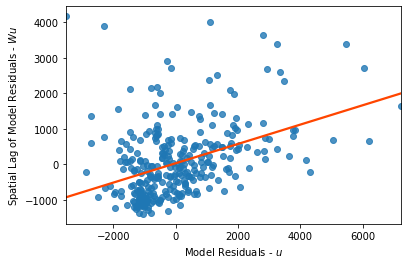

In [124]:
lag_residual = weights.spatial_lag.lag_spatial(w_new, m_ols.u)
ax = sb.regplot(
    m_ols.u.flatten(), 
    lag_residual.flatten(), 
    line_kws=dict(color='orangered'),
    ci=None
)
ax.set_xlabel('Model Residuals - $u$')
ax.set_ylabel('Spatial Lag of Model Residuals - $W u$')

We use the command `OLS`, part of the `spreg` sub-package, and specify the dependent variable (the log of the price, so we can interpret results in terms of percentage change) and the explanatory ones. Note that both objects need to be arrays, so we extract them from the `pandas.DataFrame` object using `.values`.

In order to inspect the results of the model, we can call `summary`:

### Spatial Heterogeneity

At its most basic, *spatial heterogeneity* means that parts of the model may change in different places. For example, changes to the intercept, $\alpha$, may reflect the fact that different areas have different baseline exposures to a given process. Changes to the slope terms, $\beta$, may indicate some kind of geographical mediating factor, such as when a governmental policy is not consistently applied across jurisdictions. Finally, changes to the variance of the residuals, commonly denoted $\sigma^2$, can introduce spatial heteroskedasticity.

#### Spatial Regimes

At the core of estimating spatial FEs is the idea that, instead of assuming the dependent variable behaves uniformly over space, there are systematic effects following a geographical pattern that affect its behavior. In other words, spatial FEs introduce econometrically the notion of spatial heterogeneity. They do this in the simplest possible form: by allowing the constant term to vary geographically. The other elements of the regression are left untouched and hence apply uniformly across space. The idea of spatial regimes (SRs) is to generalize the spatial FE approach to allow not only the constant term to vary but also any other explanatory variable. This implies that the equation we will be estimating is:

$$
{Y_i} = \alpha_r + \sum_k \mathbf{X}_{ki}\beta_{k-r} + \epsilon_i
$$

where we are not only allowing the constant term to vary by region ($\alpha_r$), but also every other parameter ($\beta_{k-r}$).


Programmatically, we will show two different ways can estimate this: one,
using `statsmodels`; and two, with `PySAL`. First, we will use `statsmodels`. This package provides a formula-like API, which allows us to express the *equation* we wish to estimate directly:

In [142]:
sz_df = sz_df.assign(REGION_N = sz_cpf['REGION_N'])

In [147]:
sz_df

Age_0to6  Age_20to29  Age_over85  HDB_AV_E  HDB_AV_2rm  House_AV  \
0           0          60          28         0           0         0   
1          89         147          20         0           0         0   
2        1002        1043         291         0           0         0   
3           0           0           0         0           0         0   
4           0           0           0         0           0         0   
..        ...         ...         ...       ...         ...       ...   
316      7730        3851          86         0       10514         0   
317       725        2216         109     83054           0         0   
318       139         295          44         0           0    184965   
319         0           0           0         0           0         0   
320         0           0           0         0           0         0   

     Condo_AV   EC_AV  Apart_AV   DP   FDW    WP  Ina_CPF_N           REGION_N  
0           0       0     27014   42    16   623        679     CENTRAL REGION  
1           0       0         0   53    72   101       1837     CENTRAL REGION  
2       26400       0    585179  336   573   518       1721     CENTRAL REGION  
3           0       0         0   97     0     0          0     CENTRAL REGION  
4           0       0         0  995     0     0          0     CENTRAL REGION  
..        ...     ...       ...  ...   ...   ...        ...                ...  
316    114704  201014         0  761  2309   435       9684  NORTH-EAST REGION  
317         0       0         0   18   210  7468       3205       NORTH REGION  
318         0       0     38255    0   292   329        193       NORTH REGION  
319         0       0         0    0     0     0       1247       NORTH REGION  
320         0       0         0   42     0  4805        861       NORTH REGION  

[321 rows x 14 columns]

In [133]:
f = 'Ina_CPF_N ~ ' + ' + '.join(variable_names_X) + ' + REGION_N - 1'
print(f)

Ina_CPF_N ~ Age_0to6 + Age_20to29 + Age_over85 + HDB_AV_E + HDB_AV_2rm + House_AV + Condo_AV + EC_AV + Apart_AV + DP + FDW + WP + REGION_N - 1


The *tilde* operator in this statement is usually read as "Ina_CPF_N is a function of ...", to account for the fact that many different model specifications can be fit according to that functional relationship between `Ina_CPF_N` and our covariate list. Critically, note that the trailing `-1` term means that we are fitting this model without an intercept term. This is necessary, since including an intercept term alongside unique means for every REGION would make the underlying system of equations underspecified.  

Using this expression, we can estimate the unique effects of each neighborhood, fitting the model in `statsmodels`: 

In [150]:
m_sm_regimes = ols(f, data=sz_df).fit()
print(m_sm_regimes.summary2())

                         Results: Ordinary least squares
Model:                    OLS                  Adj. R-squared:         0.892     
Dependent Variable:       Ina_CPF_N            AIC:                    5538.0988 
Date:                     2021-10-06 15:37     BIC:                    5602.2133 
No. Observations:         321                  Log-Likelihood:         -2752.0   
Df Model:                 16                   F-statistic:            166.6     
Df Residuals:             304                  Prob (F-statistic):     7.20e-140 
R-squared:                0.898                Scale:                  1.7294e+06
---------------------------------------------------------------------------------
                              Coef.   Std.Err.    t    P>|t|    [0.025    0.975] 
---------------------------------------------------------------------------------
REGION_N[CENTRAL REGION]     341.0242 146.1970  2.3326 0.0203   53.3381  628.7104
REGION_N[EAST REGION]       3313.7326 275

The approach above shows how spatial FE are a particular case of a linear regression with a categorical  variable. Region_N is modeled using binary dummy variables. Thanks to the formula grammar used in `statsmodels`, we can express the model abstractly, and Python parses it, appropriately creating binary variables as required.

The second approach leverages `PySAL` Regimes functionality, which allows the user to specify which variables are to be estimated separately for each "regime". In this case however, instead of describing the model in a formula, we need to pass each element of the model as separate arguments.

In [151]:
# PySAL implementation
m_OLS_Regimes = spreg.OLS_Regimes(
    sz_df[['Ina_CPF_N']].values, 
    sz_df[variable_names_X].values,
    sz_df['REGION_N'].tolist(),
    constant_regi='many',
    cols2regi=[False]*len(variable_names_X),
    regime_err_sep=False,
    name_y='Ina_CPF_N', 
    name_x=variable_names_X
)
print(m_OLS_Regimes.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES - REGIMES
---------------------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   Ina_CPF_N                Number of Observations:         321
Mean dependent var  :   3805.6199                Number of Variables   :          17
S.D. dependent var  :   4006.4281                Degrees of Freedom    :         304
R-squared           :      0.8976
Adjusted R-squared  :      0.8923
Sum squared residual:525725285.679                F-statistic           :    166.6348
Sigma-square        : 1729359.492                Prob(F-statistic)     :  7.203e-140
S.E. of regression  :    1315.051                Log likelihood        :   -2752.049
Sigma-square ML     : 1637773.476                Akaike info criterion :    5538.099
S.E of regression ML:   1279.7552                Schwarz criterion     :    5602.213

--------------------------------------------------------

### Spatial Dependence

Spatial Heterogeneity (SH) is about effects of phenomena that are *explicitly linked*
to geography and that hence cause spatial variation and clustering. This
encompasses many of the kinds of spatial effects we may be interested in when we fit
linear regressions. However, in other cases, our focus is on the effect of the *spatial
configuration* of the observations, and the extent to which that has an effect on the
outcome we are considering. For example, we might think that the price of a house not
only depends on whether it is a townhouse or an apartment, but also on
whether it is surrounded by many more townhouses than skyscrapers with more
apartments. This, we could hypothesize, might be related to the different "look and feel" a
neighborhood with low-height, historic buildings has as compared to one with
modern high-rises. To the extent these two different spatial configurations
enter differently the house price determination process, we will be
interested in capturing not only the characteristics of a house, but also of
its surrounding ones.
This kind of spatial effect is fundamentally different
from SH in that is it not related to inherent characteristics of the geography but relates 
to the characteristics of the observations in our dataset and, specially, to their spatial
arrangement. We call this phenomenon by which the values of observations are related to
each other through distance *spatial dependence* {cite}`Anselin_1988`.

#### Spatial Lag

The spatial lag model introduces a spatial lag of the *dependent* variable. In the example we have covered, this would translate into:

$$
{Y_i} = \alpha + \rho {Y_{lag-i}} + \sum_k \beta_k X_{ki} + \epsilon_i
$$

Although it might not seem very different from the previous equation, this model violates 
the exogeneity assumption, crucial for OLS to work. 
Put simply, this occurs when $P_i$ exists on both "sides" of the equals sign.
In theory, since $P_i$ is included in computing $P_{lag-i}$, exogeneity is violated. 
Similarly to the case of
the spatial error, several techniques have been proposed to overcome this
limitation, and `PySAL` implements several of them. In the example below, we
use a two-stage least squares estimation {cite}`Anselin_1988`, where the spatial
lag of all the explanatory variables is used as instrument for the endogenous
lag:

In [152]:
m_GM_Lag = spreg.GM_Lag(
    sz_df[['Ina_CPF_N']].values, 
    sz_df[variable_names_X].values,
    w=w_new,
    name_y='Ina_CPF_N',
    name_x=variable_names_X
)
print(m_GM_Lag.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   Ina_CPF_N                Number of Observations:         321
Mean dependent var  :   3805.6199                Number of Variables   :          14
S.D. dependent var  :   4006.4281                Degrees of Freedom    :         307
Pseudo R-squared    :      0.9896
Spatial Pseudo R-squared:  0.9759

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT    -505.5846066      40.8002822     -12.3916939       0.0000000
            Age_0to6       0.1956513       0.0434049       4.5075832       0.0000066
          Age_20to29       0.5792295       0.0260074      2

<AxesSubplot:>

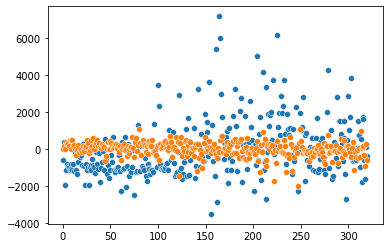

In [153]:
sb.scatterplot(x=list(range(0,321)),y=m_ols.u.flatten())
sb.scatterplot(x=list(range(0,321)),y=m_GM_Lag.u.flatten())

#### Exogenous effects: The SLX Model

The most straightforward way to introduce spatial dependence in a regression is by 
considering not only a given explanatory variable, but also its spatial lag. In our
example case, in addition to including a dummy for the type of house (`pg_XXX`), we 
can also include the spatial lag of each type of house. This addition implies
we are also including as explanatory factor of the price of a given house the proportion 
neighboring houses in each type. Mathematically, this implies estimating the following model:

$$
Y_i = \alpha + \sum^{p}_{k=1}X_{ij}\beta_j + \sum^{p}_{k=1}\left(\sum^{N}_{j=1}w_{ij}x_{jk}\right)\gamma_k + \epsilon_i
$$

where $\sum_{j=1}^N w_{ij}x_{jk}$ represents the spatial lag of the $k$th explanatory variable.
This can be stated in *matrix* form using the spatial weights matrix, $\mathbf{W}$, as:
$$
Y = \alpha + \mathbf{X}\beta + \mathbf{WX}\gamma + \epsilon
$$

This splits the model to focus on two main effects: $\beta$ and $\gamma$. The
$\beta$ effect describes the change in $y_i$ when $X_{ik}$ changes by one. 
 

Indeed, this matters for the $\gamma$ effect, which represents an 
*indirect* effect of a change in $X_i$. This can be conceptualized in two ways. 
First, one could think of $\gamma$ as simply *the effect of a unit change in your average surroundings.*
This is useful and simple. But, this interpretation ignores where this change
might occur. In truth, a change in a variable at site $i$ will result in a *spillover* to its surroundings:
when $x_i$ changes, so too does the *spatial lag* of any site near $i$. 
The precise size of this will depend on the structure of $\mathbf{W}$, and can be 
different for every site. For example, think of a very highly-connected "focal" site in a 
row-standardized weight matrix. This focal site will not be strongly affected 
if a neighbor changes by a single unit, since each site only contributes a 
small amount to the lag at the focal site. Alternatively, consider a site with only 
one neighbor: its lag will change by *exactly* the amount its sole neighbor changes.
Thus, to discover the exact indirect effect of a change $y$ caused by the change
at a specific site $x_i$ you would need to compute the *change in the spatial lag*,
and then use that as your *change* in $X$. 


Introducing a spatial lag of an explanatory variable is the most straightforward way of incorporating the notion of spatial dependence in a linear regression framework. It does not require additional changes, it can be estimated with OLS, and the interpretation is rather similar to interpreting non-spatial variables, so long as aggregate changes are required. 

#### Spatial Error

The spatial error model includes a spatial lag in the *error* term of the equation:

$$
{Y_i} = \alpha + \sum_k \beta_k X_{ki} + u_i
$$

$$
u_i = \lambda u_{lag-i} + \epsilon_i
$$

where $u_{lag-i} = \sum_j w_{i,j} u_j$. 
Although it appears similar, this specification violates the assumptions about the
error term in a classical OLS model. Hence, alternative estimation methods are
required. `PySAL` incorporates functionality to estimate several of the most
advanced techniques developed by the literature on spatial econometrics. For
example, we can use a general method of moments that account for 
heterogeneity (Arraiz et al., 2010):

#### Other ways of bringing space into regression

While these are some kinds of spatial regressions, many other advanced spatial regression methods see routine use in statistics, data science, and applied analysis. For example, Generalized Additive Models {cite}`Gibbons_2015,Wood_2006` haven been used to apply spatial kernel smoothing directly within a regression function. Other similar smoothing methods, such as spatial Gaussian process models {cite}`Brunsdon_2010` or Kriging, conceptualize the dependence between locations as smooth as well. Other methods in spatial regression that consider graph-based geographies (rather than distance/kernel effects) include variations on conditional autoregressive model, which examines spatial relationships at locations *conditional* on their surroundings, rather than as jointly co-emergent with them. Full coverage of these topics is beyond the scope of this book, however, though {cite}`Banerjee_2008` provides a detailed and comprehensive discussion. 

## Panel Data & Spatial Pancel Model

In statistics and econometrics, panel data and longitudinal data are both multi-dimensional data involving measurements over time. Panel data is a subset of longitudinal data where observations are for the same subjects each time. Time series and cross-sectional data can be thought of as special cases of panel data that are in one dimension only. Let's use the height and weight data used at the beginning of the session as an example.

In [206]:
dataset

const  Gender     Height      Weight        res        pred     res_z  \
0       1.0    Male  73.847017  241.893563  26.133192  215.760371  2.610060   
1       1.0    Male  68.781904  162.310473 -23.252841  185.563314 -2.322384   
2       1.0    Male  74.110105  212.740856  -4.587989  217.328845 -0.458227   
3       1.0    Male  71.730978  220.042470  16.897442  203.145028  1.687637   
4       1.0    Male  69.881796  206.349801  14.229181  192.120620  1.421143   
...     ...     ...        ...         ...        ...         ...       ...   
9995    1.0  Female  66.172652  136.777454 -13.851242  150.628696 -1.383397   
9996    1.0  Female  67.067155  170.867906  14.877520  155.990386  1.485896   
9997    1.0  Female  63.867992  128.475319  -8.339138  136.814457 -0.832874   
9998    1.0  Female  69.034243  163.852461  -3.928744  167.781206 -0.392384   
9999    1.0  Female  61.944246  113.649103 -11.634329  125.283432 -1.161982   

     Nationality      X          Y  
0      Country 1    0.0   0.000000  
1      Country 2  100.0   0.000000  
2      Country 3   50.0  70.710678  
3      Country 1    0.0   0.000000  
4      Country 3   50.0  70.710678  
...          ...    ...        ...  
9995   Country 3   50.0  70.710678  
9996   Country 3   50.0  70.710678  
9997   Country 3   50.0  70.710678  
9998   Country 3   50.0  70.710678  
9999   Country 3   50.0  70.710678  

[10000 rows x 10 columns]

In [207]:
dataset_panel= dataset.loc[:,['Gender','Height','Weight']].copy()

In [208]:
dataset_panel=dataset_panel.rename(columns={'Height':'Height_Age_18','Weight':'Weight_Age_18'})

In [209]:
dataset_panel = dataset_panel.assign(Height_Age_20 = dataset_panel['Height_Age_18']+np.random.normal(2,0.2,len(dataset_panel)),
                    Weight_Age_20 = dataset_panel['Weight_Age_18']+ 0.5 * np.random.normal(2,0.2,len(dataset_panel)))
dataset_panel

Gender  Height_Age_18  Weight_Age_18  Height_Age_20  Weight_Age_20
0       Male      73.847017     241.893563      75.914748     242.804509
1       Male      68.781904     162.310473      71.072789     163.228835
2       Male      74.110105     212.740856      75.804096     213.902106
3       Male      71.730978     220.042470      73.982934     220.951715
4       Male      69.881796     206.349801      72.029979     207.414404
...      ...            ...            ...            ...            ...
9995  Female      66.172652     136.777454      68.130255     137.932879
9996  Female      67.067155     170.867906      69.152860     171.933928
9997  Female      63.867992     128.475319      66.188477     129.615229
9998  Female      69.034243     163.852461      70.973962     164.909507
9999  Female      61.944246     113.649103      64.040688     114.488471

[10000 rows x 5 columns]

In [210]:
from statsmodels.stats.anova import AnovaRM

In [211]:
# add subject ID
dataset_panel['Sub_ID']=dataset_panel.index +1

In [212]:
dataset_panel

Gender  Height_Age_18  Weight_Age_18  Height_Age_20  Weight_Age_20  \
0       Male      73.847017     241.893563      75.914748     242.804509   
1       Male      68.781904     162.310473      71.072789     163.228835   
2       Male      74.110105     212.740856      75.804096     213.902106   
3       Male      71.730978     220.042470      73.982934     220.951715   
4       Male      69.881796     206.349801      72.029979     207.414404   
...      ...            ...            ...            ...            ...   
9995  Female      66.172652     136.777454      68.130255     137.932879   
9996  Female      67.067155     170.867906      69.152860     171.933928   
9997  Female      63.867992     128.475319      66.188477     129.615229   
9998  Female      69.034243     163.852461      70.973962     164.909507   
9999  Female      61.944246     113.649103      64.040688     114.488471   

      Sub_ID  
0          1  
1          2  
2          3  
3          4  
4          5  
...      ...  
9995    9996  
9996    9997  
9997    9998  
9998    9999  
9999   10000  

[10000 rows x 6 columns]

In [213]:
# wide to long for statsmodel
dataset_panel_long = pd.wide_to_long(dataset_panel, ["Height_Age", "Weight_Age"], i=["Sub_ID","Gender"], j="Age", sep="_").reset_index()
dataset_panel_long

Sub_ID  Gender  Age  Height_Age  Weight_Age
0           1    Male   18   73.847017  241.893563
1           1    Male   20   75.914748  242.804509
2           2    Male   18   68.781904  162.310473
3           2    Male   20   71.072789  163.228835
4           3    Male   18   74.110105  212.740856
...       ...     ...  ...         ...         ...
19995    9998  Female   20   66.188477  129.615229
19996    9999  Female   18   69.034243  163.852461
19997    9999  Female   20   70.973962  164.909507
19998   10000  Female   18   61.944246  113.649103
19999   10000  Female   20   64.040688  114.488471

[20000 rows x 5 columns]

In [215]:
test_df=dataset_panel_long.iloc[np.r_[0:20,10000:10020],:]
test_df

Sub_ID  Gender  Age  Height_Age  Weight_Age
0           1    Male   18   73.847017  241.893563
1           1    Male   20   75.914748  242.804509
2           2    Male   18   68.781904  162.310473
3           2    Male   20   71.072789  163.228835
4           3    Male   18   74.110105  212.740856
5           3    Male   20   75.804096  213.902106
6           4    Male   18   71.730978  220.042470
7           4    Male   20   73.982934  220.951715
8           5    Male   18   69.881796  206.349801
9           5    Male   20   72.029979  207.414404
10          6    Male   18   67.253016  152.212156
11          6    Male   20   68.933117  153.263450
12          7    Male   18   68.785081  183.927889
13          7    Male   20   70.850997  184.954924
14          8    Male   18   68.348516  167.971110
15          8    Male   20   70.367896  169.008834
16          9    Male   18   67.018950  175.929440
17          9    Male   20   69.119381  176.705508
18         10    Male   18   63.456494  156.399676
19         10    Male   20   65.799226  157.505027
10000    5001  Female   18   58.910732  102.088326
10001    5001  Female   20   60.694570  103.208097
10002    5002  Female   18   65.230013  141.305823
10003    5002  Female   20   67.201355  142.092617
10004    5003  Female   18   63.369004  131.041403
10005    5003  Female   20   65.214611  132.074020
10006    5004  Female   18   64.479997  128.171511
10007    5004  Female   20   66.359572  129.162664
10008    5005  Female   18   61.793096  129.781407
10009    5005  Female   20   63.546869  130.807911
10010    5006  Female   18   65.968019  156.802083
10011    5006  Female   20   68.180838  157.997151
10012    5007  Female   18   62.850379  114.969038
10013    5007  Female   20   64.923250  115.987658
10014    5008  Female   18   65.652156  165.083001
10015    5008  Female   20   67.518809  165.954359
10016    5009  Female   18   61.890234  111.676199
10017    5009  Female   20   64.017923  112.526697
10018    5010  Female   18   63.677868  104.151560
10019    5010  Female   20   65.709571  104.970687

In [216]:
aovrm = AnovaRM(test_df, 'Height_Age', 'Sub_ID', within=['Age'])
res = aovrm.fit()

print(res)

               Anova
     F Value  Num DF  Den DF Pr > F
-----------------------------------
Age 2095.3421 1.0000 19.0000 0.0000



## Spatial Interpoloation (Optional)

Spatial interpolation is the procedure of estimating the value of properties at unsampled sites within the area covered by existing observations.

In statistics, originally in geostatistics, kriging or Kriging, also known as Gaussian process regression, is a method of interpolation based on Gaussian process governed by prior covariances. The basic idea of kriging is to predict the value of a function at a given point by computing a weighted average of the known values of the function in the neighborhood of the point.

The theoretical basis for the method was developed by the French mathematician *Georges Matheron* in 1960, based on the Master's thesis of Danie G. Krige, the pioneering plotter of distance-weighted average gold grades at the Witwatersrand reef complex in South Africa. Krige sought to estimate the most likely distribution of gold based on samples from a few boreholes. The English verb is to krige and the most common noun is kriging; both are often pronounced with a hard "g", following an Anglicized pronunciation of the name "Krige". The word is sometimes capitalized as Kriging in the literature.

In [217]:
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging
from pykrige.uk import UniversalKriging
import matplotlib.pyplot as plt
import seaborn as sb
import gstools as gs

### Download Singapore Rainfall Data

In [218]:
from datetime import datetime
import json
from pandas import json_normalize
import requests
dt_string = "2020-12-01" 

format = "%Y-%m-%d"
dt_object = datetime.strptime(dt_string, format)
dt_object.date()
datelist = pd.date_range(dt_object.date(), periods=10).tolist()

# download 10 days Singapore rainfall data
# responses = [requests.get('https://api.data.gov.sg/v1/environment/rainfall?date='+i.strftime("%Y-%m-%d")) for i in datelist]
# [print(i.status_code) for i in responses]

# for i,response in enumerate(responses):
#     with open(f'Data/Rainfall/test{i}.json', 'w') as f:
#         json.dump(response.json(), f)

In [219]:
import os
responses_json =[]
for filename in os.listdir('Data/Rainfall'):
    with open(os.path.join('Data/Rainfall', filename), 'r') as f: # open in readonly mode
        response = json.load(f)
        responses_json.append(response)

### Preprocessing Rainfall Data

In [220]:
# df_dict=responses[0].json() # if use online download
df_dict=responses_json[0] # if read files

In [221]:
df_dict['metadata']['stations']

[{'id': 'S77',
  'device_id': 'S77',
  'name': 'Alexandra Road',
  'location': {'latitude': 1.2937, 'longitude': 103.8125}},
 {'id': 'S117',
  'device_id': 'S117',
  'name': 'Banyan Road',
  'location': {'latitude': 1.256, 'longitude': 103.679}},
 {'id': 'S90',
  'device_id': 'S90',
  'name': 'Bukit Timah Road',
  'location': {'latitude': 1.3191, 'longitude': 103.8191}},
 {'id': 'S61',
  'device_id': 'S61',
  'name': 'Chai Chee Street',
  'location': {'latitude': 1.323, 'longitude': 103.9217}},
 {'id': 'S114',
  'device_id': 'S114',
  'name': 'Choa Chu Kang Avenue 4',
  'location': {'latitude': 1.38, 'longitude': 103.73}},
 {'id': 'S11',
  'device_id': 'S11',
  'name': 'Choa Chu Kang Road',
  'location': {'latitude': 1.3746, 'longitude': 103.6938}},
 {'id': 'S50',
  'device_id': 'S50',
  'name': 'Clementi Road',
  'location': {'latitude': 1.3337, 'longitude': 103.7768}},
 {'id': 'S107',
  'device_id': 'S107',
  'name': 'East Coast Parkway',
  'location': {'latitude': 1.3135, 'longitude

In [222]:
df_stations = pd.DataFrame(df_dict['metadata']['stations'])

In [223]:
df_stations

id device_id                    name  \
0    S77       S77          Alexandra Road   
1   S117      S117             Banyan Road   
2    S90       S90        Bukit Timah Road   
3    S61       S61        Chai Chee Street   
4   S114      S114  Choa Chu Kang Avenue 4   
..   ...       ...                     ...   
70  S230      S230                    S230   
71   S92       S92  South Buona Vista Road   
72   S29       S29      Pasir Ris Drive 12   
73  S122      S122          Sembawang Road   
74  S109      S109     Ang Mo Kio Avenue 5   

                                         location  
0     {'latitude': 1.2937, 'longitude': 103.8125}  
1       {'latitude': 1.256, 'longitude': 103.679}  
2     {'latitude': 1.3191, 'longitude': 103.8191}  
3      {'latitude': 1.323, 'longitude': 103.9217}  
4         {'latitude': 1.38, 'longitude': 103.73}  
..                                            ...  
70  {'latitude': 1.30167, 'longitude': 103.76444}  
71    {'latitude': 1.2841, 'longitude': 103.7886}  
72      {'latitude': 1.387, 'longitude': 103.935}  
73   {'latitude': 1.41731, 'longitude': 103.8249}  
74    {'latitude': 1.3764, 'longitude': 103.8492}  

[75 rows x 4 columns]

In [20]:
df_st= df_stations.drop('location', axis=1).join(pd.DataFrame(df_stations.location.values.tolist()))
df_st

id device_id                    name  latitude  longitude
0    S77       S77          Alexandra Road   1.29370  103.81250
1   S117      S117             Banyan Road   1.25600  103.67900
2    S90       S90        Bukit Timah Road   1.31910  103.81910
3    S61       S61        Chai Chee Street   1.32300  103.92170
4   S114      S114  Choa Chu Kang Avenue 4   1.38000  103.73000
..   ...       ...                     ...       ...        ...
70  S230      S230                    S230   1.30167  103.76444
71   S92       S92  South Buona Vista Road   1.28410  103.78860
72   S29       S29      Pasir Ris Drive 12   1.38700  103.93500
73  S122      S122          Sembawang Road   1.41731  103.82490
74  S109      S109     Ang Mo Kio Avenue 5   1.37640  103.84920

[75 rows x 5 columns]

In [21]:
# uncomment the following line if you use online requests
# df_rainfall = [pd.DataFrame(response.json()['items']).assign(Day_ID=i+1, Time_ID = pd.DataFrame(response.json()['items']).index+1) for i,response in enumerate(responses)]

# uncomment the next line if you use files in rainfall folder
df_rainfall = [pd.DataFrame(response['items']).assign(Day_ID=i+1, Time_ID = pd.DataFrame(response['items']).index+1) for i,response in enumerate(responses_json)]

In [22]:
df_rainfall_all =pd.concat(df_rainfall, axis=0)

In [23]:
df_rainfall_all

timestamp  \
0    2020-12-01T00:05:00+08:00   
1    2020-12-01T00:10:00+08:00   
2    2020-12-01T00:15:00+08:00   
3    2020-12-01T00:20:00+08:00   
4    2020-12-01T00:25:00+08:00   
..                         ...   
282  2020-12-10T23:35:00+08:00   
283  2020-12-10T23:40:00+08:00   
284  2020-12-10T23:45:00+08:00   
285  2020-12-10T23:50:00+08:00   
286  2020-12-10T23:55:00+08:00   

                                              readings  Day_ID  Time_ID  
0    [{'station_id': 'S77', 'value': 0}, {'station_...       1        1  
1    [{'station_id': 'S77', 'value': 0}, {'station_...       1        2  
2    [{'station_id': 'S77', 'value': 0}, {'station_...       1        3  
3    [{'station_id': 'S77', 'value': 0}, {'station_...       1        4  
4    [{'station_id': 'S77', 'value': 0}, {'station_...       1        5  
..                                                 ...     ...      ...  
282  [{'station_id': 'S77', 'value': 0}, {'station_...      10      283  
283  [{'station_id': 'S77', 'value': 0}, {'station_...      10      284  
284  [{'station_id': 'S77', 'value': 0}, {'station_...      10      285  
285  [{'station_id': 'S77', 'value': 0}, {'station_...      10      286  
286  [{'station_id': 'S77', 'value': 0}, {'station_...      10      287  

[2870 rows x 4 columns]

In [24]:
df = pd.concat([pd.DataFrame(row.readings).assign(Day_ID=row.Day_ID,Time_ID=row.Time_ID) for index, row in df_rainfall_all.iterrows()]).reset_index()
df

index station_id  value  Day_ID  Time_ID
0           0        S77    0.0       1        1
1           1       S117    0.0       1        1
2           2        S90    0.0       1        1
3           3        S61    0.0       1        1
4           4       S114    0.0       1        1
...       ...        ...    ...     ...      ...
211283     68        S08    0.0      10      287
211284     69       S116    0.0      10      287
211285     70       S104    0.0      10      287
211286     71       S100    0.0      10      287
211287     72        S91    0.0      10      287

[211288 rows x 5 columns]

In [25]:
df_agg= df.groupby(['Day_ID','station_id']).sum().drop(['Time_ID','index'],axis=1).reset_index()

In [26]:
df_agg

Day_ID station_id  value
0         1        S07    0.0
1         1        S08    0.0
2         1       S100    0.0
3         1       S104    0.0
4         1       S107    0.0
..      ...        ...    ...
747      10        S90    5.6
748      10       S900   43.6
749      10        S91   19.8
750      10        S92    5.6
751      10        S94   18.6

[752 rows x 3 columns]

In [27]:
df_stations

id device_id                    name  \
0    S77       S77          Alexandra Road   
1   S117      S117             Banyan Road   
2    S90       S90        Bukit Timah Road   
3    S61       S61        Chai Chee Street   
4   S114      S114  Choa Chu Kang Avenue 4   
..   ...       ...                     ...   
70  S230      S230                    S230   
71   S92       S92  South Buona Vista Road   
72   S29       S29      Pasir Ris Drive 12   
73  S122      S122          Sembawang Road   
74  S109      S109     Ang Mo Kio Avenue 5   

                                         location  
0     {'latitude': 1.2937, 'longitude': 103.8125}  
1       {'latitude': 1.256, 'longitude': 103.679}  
2     {'latitude': 1.3191, 'longitude': 103.8191}  
3      {'latitude': 1.323, 'longitude': 103.9217}  
4         {'latitude': 1.38, 'longitude': 103.73}  
..                                            ...  
70  {'latitude': 1.30167, 'longitude': 103.76444}  
71    {'latitude': 1.2841, 'longitude': 103.7886}  
72      {'latitude': 1.387, 'longitude': 103.935}  
73   {'latitude': 1.41731, 'longitude': 103.8249}  
74    {'latitude': 1.3764, 'longitude': 103.8492}  

[75 rows x 4 columns]

In [40]:
df_agg_for_kriging = df_agg.merge(df_st,left_on='station_id',right_on='device_id')

In [41]:
df_agg_for_kriging

Day_ID station_id     value   id device_id                 name  \
0         1        S07   0.00000  S07       S07          Lornie Road   
1         2        S07   0.20000  S07       S07          Lornie Road   
2         3        S07  33.00000  S07       S07          Lornie Road   
3         4        S07  21.40000  S07       S07          Lornie Road   
4         5        S07   0.20000  S07       S07          Lornie Road   
..      ...        ...       ...  ...       ...                  ...   
736       6        S94   0.00000  S94       S94  Pasir Ris Street 51   
737       7        S94  19.00000  S94       S94  Pasir Ris Street 51   
738       8        S94   0.00000  S94       S94  Pasir Ris Street 51   
739       9        S94  64.19999  S94       S94  Pasir Ris Street 51   
740      10        S94  18.60000  S94       S94  Pasir Ris Street 51   

     latitude  longitude  
0      1.3415   103.8334  
1      1.3415   103.8334  
2      1.3415   103.8334  
3      1.3415   103.8334  
4      1.3415   103.8334  
..        ...        ...  
736    1.3662   103.9528  
737    1.3662   103.9528  
738    1.3662   103.9528  
739    1.3662   103.9528  
740    1.3662   103.9528  

[741 rows x 8 columns]

### Visualize Rainfall data

In [31]:
import geopandas as gp

In [42]:
df_rainfall_geoms = gp.points_from_xy(x=df_agg_for_kriging["longitude"],
                                    y=df_agg_for_kriging["latitude"],
                                    crs="epsg:4326"
                                   )

In [43]:
rainfall = gp.GeoDataFrame(df_agg_for_kriging,
                                   geometry=df_rainfall_geoms
                                  )

In [44]:
# ensure that the two layers have the same crs
# here we have to transform the crs instead of set a new
rainfall=rainfall.to_crs("epsg:3414")

In [45]:
sz = gp.read_file('Data/MP14_Subzone_SE_2017.shp')

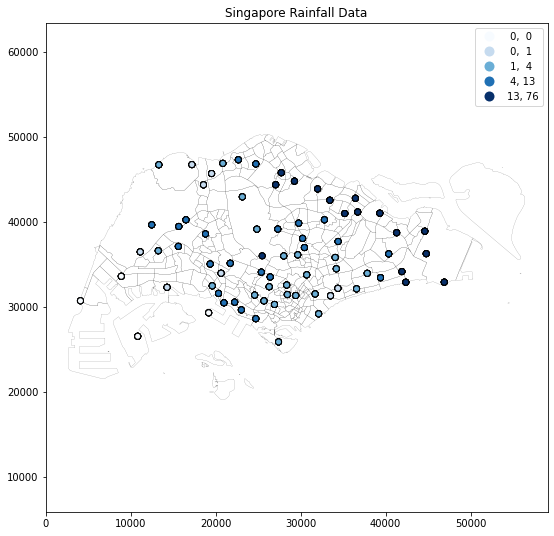

In [46]:
f, ax = plt.subplots(1, figsize=(9, 9))
sz.plot(ax=ax, legend=False, facecolor="none",edgecolor="k",lw=0.1)
rainfall.plot(ax=ax, column='value', legend=True, scheme='Quantiles', legend_kwds={'fmt':'{:.0f}'}, cmap='Blues', edgecolor="k")
ax.set_title('Singapore Rainfall Data')
plt.axis('equal')
plt.show()

In [54]:
rainfall.dtypes

Day_ID           int64
station_id      object
value          float64
id              object
device_id       object
name            object
latitude       float64
longitude      float64
geometry      geometry
dtype: object

In [124]:
rainfall_day=rainfall.query('Day_ID == 3')

In [91]:
extent = min_x, max_x, min_y, max_y = [rainfall.geometry.x.min()-1000, rainfall.geometry.x.max()+1000,
                                       rainfall.geometry.y.min()-1000, rainfall.geometry.y.max()+1000]

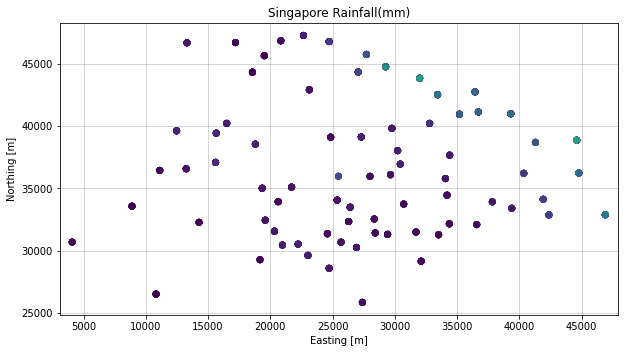

In [92]:
fig, ax = plt.subplots(figsize=(10,6))

ax.scatter(rainfall.geometry.x, rainfall.geometry.y, c=rainfall.value)
ax.set_aspect(1)
ax.set_xlim(*extent[:2])
ax.set_ylim(*extent[2:])
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')
ax.set_title('Singapore Rainfall(mm)')
ax.grid(c='k', alpha=0.2)

plt.show()

### Make a regular grid

We must make a grid, which represents the points we'd like to predict.

In [60]:
gridx, gridy = np.mgrid[min_x:max_x:500, min_y:max_x:500]

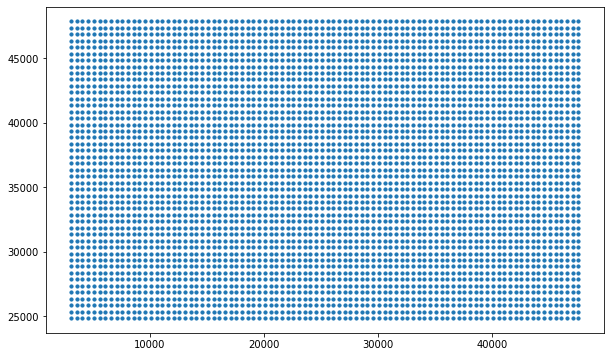

In [62]:
plt.figure(figsize=(10,6))
plt.scatter(gridx, gridy, s=10)

### Interpolation with radial basis function

Now we make an interpolator and use it to predict into the grid 'cells'.

In [97]:
from scipy.interpolate import Rbf

# Make an n-dimensional interpolator. 

rbfi = Rbf(rainfall_day.geometry.x, rainfall_day.geometry.y, rainfall_day.value)

# Predict on the regular grid. Line 5.
di = rbfi(gridx, gridy)

Let's plot the result. First, we'll need the min and max of the combined sparse and gridded data, so we can plot them with the same colourmap ranges:

In [98]:
mi = np.min(np.hstack([di.ravel(), rainfall_day.value.values]))
ma = np.max(np.hstack([di.ravel(), rainfall_day.value.values]))

Notice the transpose and the `origin='lower'`, to keep everything matched up with the original dataset.

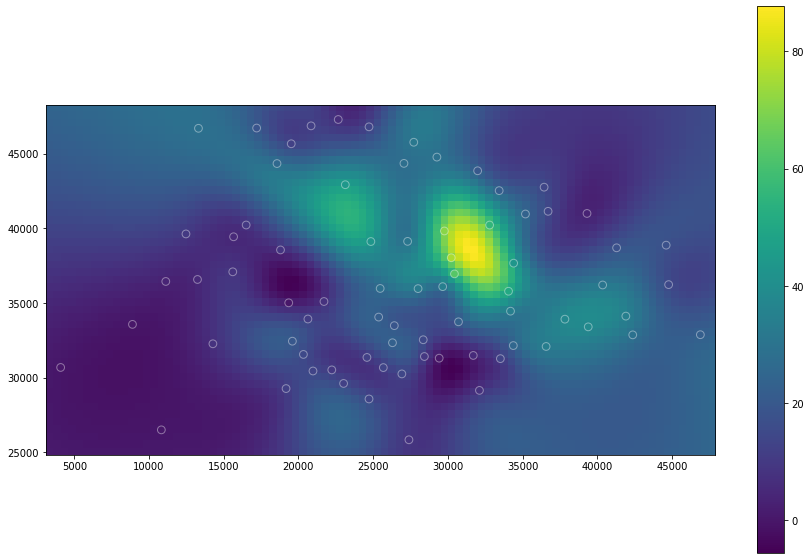

In [99]:
plt.figure(figsize=(15,15))
c1 = plt.imshow(di.T, origin="lower", extent=extent, vmin=mi, vmax=ma)
c2 = plt.scatter(rainfall_day.geometry.x, rainfall_day.geometry.y, s=60, c=rainfall_day.value, edgecolor='#ffffff66', vmin=mi, vmax=ma)

plt.colorbar(c1, shrink=0.67)
plt.show()

The circles (the data) are the same colour as the grid (the model), so we can see that the error on this prediction is almost zero. In fact, the default parameters force the model to pass through all the data points (interpolation, as opposed to estimation or approximation).

The `Rbf()` interpolator has [a few options](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.Rbf.html). The most important one is probably `smooth`, which is the thing to increase if you end up with a singular matrix (because it can't converge on a solution). Anything above 0 relaxes the constraint that the surface must pass through every point. If you get an error, you probably need to change the smoothing.

You can also change the `function` (default is `multiquadric`, which also has an `epsilon` parameter to vary the range of influence of each point).

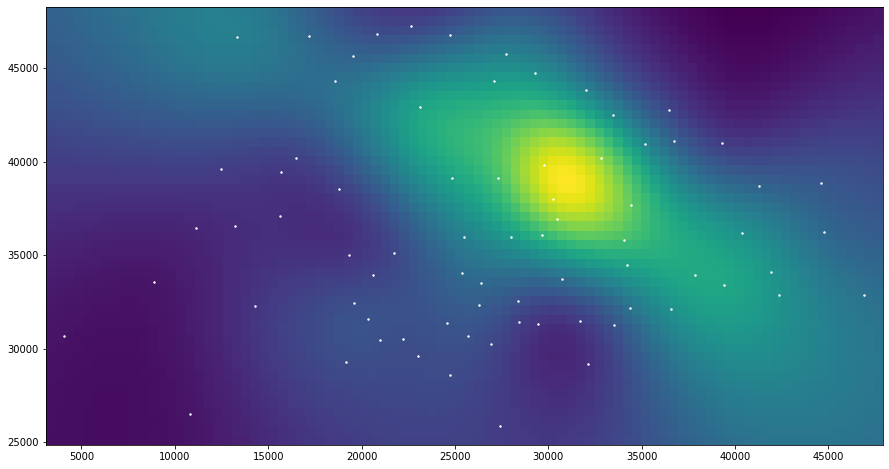

In [100]:
rbfi = Rbf(rainfall_day.geometry.x, rainfall_day.geometry.y, rainfall_day.value, smooth=0.2)
di = rbfi(gridx, gridy)

fig, ax = plt.subplots(figsize=(15,15))
plt.imshow(di.T, origin="lower", extent=extent)
plt.scatter(rainfall_day.geometry.x, rainfall_day.geometry.y, s=2, c='w')
plt.show()


We can also make a histogram and kernel density estimation of the errors, by making predictions at the original input locations:

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='value', ylabel='Density'>

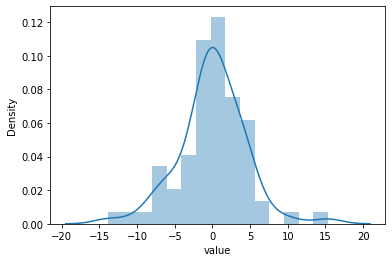

In [78]:
value_hat = rbfi(rainfall_day.geometry.x, rainfall_day.geometry.y)

sb.distplot(value_hat - rainfall_day.value)

With the smoothing set to 0.2, we end up with a smoother surface, but pay for it with larger errors.

### Interpolation with `scipy.griddata()`

The `Rbf()` interpolator is the one to know about, because it has lots of useful parameters. It's probably the only one you need to know. But there is also `scipy.griddata()`. For example see [this SciPy recipe](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.interpolate.griddata.html).

The interface is slightly different &mdash; we have to pass a single array of the coordinates (the (x, y) locations of the points we know). We also pass the values to interpolate, and the grids.

The function will not accept Pandas `Series` objects, so we'll use the `Series.values` attribute to get at the NumPy array representation.

First, let's make the 2D array of coordinates:

In [86]:
points = np.vstack((rainfall_day.geometry.x,rainfall_day.geometry.y)).T

In [87]:
points.shape

(75, 2)

The grdding step is easy. We'll try three different algorithms:

In [88]:
from scipy.interpolate import griddata

grid_z0 = griddata(points, rainfall_day.value.values, (gridx, gridy), method='nearest')
grid_z1 = griddata(points, rainfall_day.value.values, (gridx, gridy), method='linear')
grid_z2 = griddata(points, rainfall_day.value.values, (gridx, gridy), method='cubic')

Inspect the results.

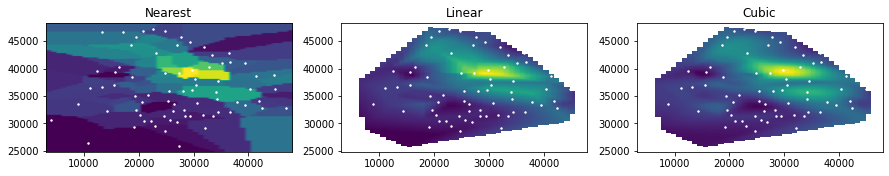

In [89]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

ax = axs[0]
ax.imshow(grid_z0, origin='lower', extent=extent)
ax.scatter(rainfall_day.geometry.x,rainfall_day.geometry.y, s=2, c='w')
ax.set_title('Nearest')

ax = axs[1]
ax.imshow(grid_z1, origin='lower', extent=extent)
ax.scatter(rainfall_day.geometry.x,rainfall_day.geometry.y, s=2, c='w')
ax.set_title('Linear')

ax = axs[2]
ax.imshow(grid_z2, origin='lower', extent=extent)
ax.scatter(rainfall_day.geometry.x,rainfall_day.geometry.y, s=2, c='w')
ax.set_title('Cubic')

plt.show()

### Using `sklearn.gaussian_process`

Modeling with a Gaussian process is equivalent to kriging. Conveniently, the popular machine learning library `scikit-learn` has a Gaussian process modeling tool.

In [125]:
from sklearn.gaussian_process.kernels import RBF

kernel = RBF(length_scale=1000)

The main hyperparameters are the kernel, which we just defined, and `alpha`, which controls the smoothness. Larger values imply mmore noise in the input data, and result in smoother grids; default is very small: 1 &times; 10<sup>-9</sup>.

In [126]:
from sklearn.gaussian_process import GaussianProcessRegressor

gp = GaussianProcessRegressor(normalize_y=True,
                              alpha=0.1,  # Larger values imply more noise in the input data.
                              kernel=kernel)

gp.fit(points, rainfall_day.value.values)

GaussianProcessRegressor(alpha=0.1, kernel=RBF(length_scale=1e+03),
                         normalize_y=True)

To make a prediction, we need to construct the X matrix: (x, y) coordinates in 2 columns:

In [127]:
X_grid = np.stack([gridx.ravel(), gridy.ravel()]).T

Now we can make a prediction:

In [128]:
y_grid = gp.predict(X_grid).reshape(gridx.shape)

And plot the predicted grid with the input data using the same colourmap:

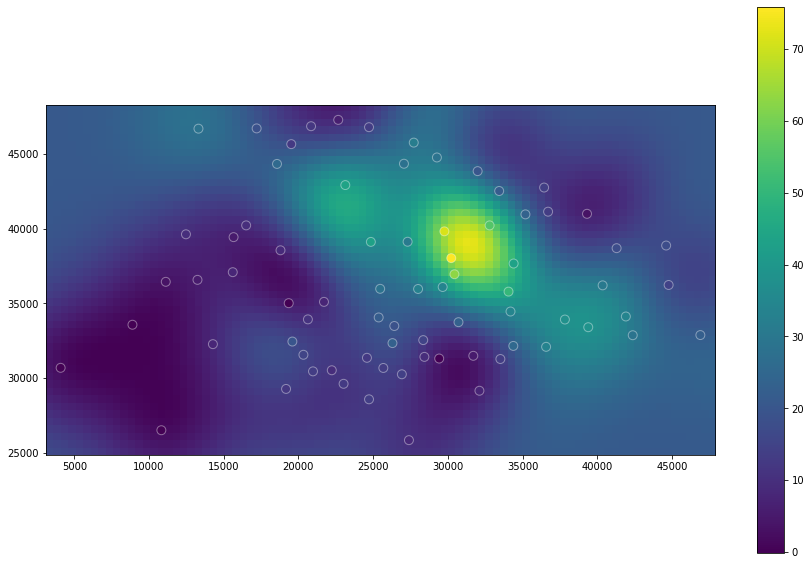

In [129]:
# Compute min and max of all the data:
mi = np.min(np.hstack([y_grid.ravel(), rainfall_day.value.values]))
ma = np.max(np.hstack([y_grid.ravel(), rainfall_day.value.values]))

# Plot it all.
plt.figure(figsize=(15,15))
im = plt.imshow(y_grid.T, origin='lower', extent=extent, vmin=mi, vmax=ma)
pts = plt.scatter(rainfall_day.geometry.x, rainfall_day.geometry.y, c=rainfall_day.value, s=80, edgecolor='#ffffff66', vmin=mi, vmax=ma)
plt.colorbar(im, shrink=0.67)
plt.show()

As before, we can compute the error by making a prediction on the original (x, y) values and comparing to the actual measured porosities at those locations:

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='value', ylabel='Density'>

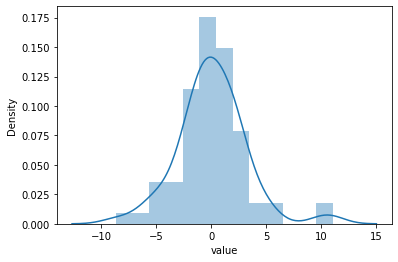

In [130]:
value_hat = gp.predict(points)

sb.distplot(value_hat - rainfall_day.value)

# References

[Geographic Data Science with PySAL and the PyData Stack](https://geographicdata.science/book/intro.html)

https://www.statsmodels.org/dev/gettingstarted.html